### This is the Exploratory Data Analysis notebook for the paper machine sheet break dataset listed below.

#### Business Case
Identifying an impending process interuption, fault or failure in advance to warn operators to take remedial action, or program the process control system to take a different action than maintaining readings within set point ranges may reduce the number of process interuptions, thus improving production and reducing costs.

#### Assumptions
1. Process variation within set point limits or specific or correlated deviation by a subset of measurements may provide advance indication of an upcoming failure.
2. Some, but not all sheet breaks may occur due to rapid deviation in a control point or an external issue such as a power failure, auxiliary equipment failure, or human intervention - some type of emergency shut down.
3. Other sheet breaks may result from a combined effect of two or several process measurements where the deviation of each is within limits, but the combined effect leads to a sheet break.  Otherwise the proces control if running within set limits should prevent a sheet break.  If the assumption of combined deviation does not hold, then most sheet breaks are a result of some variation of auxhiliary equipment mal-function that the process control system cannot correct. 

### Reference and Dataset Licence

### Dataset: Rare Event Classification in Multivariate Time Series
 ### 2018-10-01  Chitta Ranjan, Markku Mustonen, Kamran Paynabar, Karim Pourak
### https://deeplearn.org/arxiv/48599/dataset:-rare-event-classification-in-multivariate-time-series

### EDA
    - Import dataset & view data feature types and info
    - Explore integer / categorical features
    - Plot feature distributions for normal (0) and sheet break (1) conditions
    - Add a new feature category labelling time samples ahead of the actual break and investigate feature variation
    - Do a preliminary feature importance using Random Forest Classsifier using the new labels.
    - Produce a heatmap on the full data set and balancing on the new labels reducing the number normal condition samples.
    - Produce Parplots and Relplots focusing on interesting features. 

In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df=pd.read_csv('processminer-rare-event-mts - data.csv')

In [3]:
df.head()

time  y        x1        x2        x3         x4        x5  \
0  5/1/99 0:00  0  0.376665 -4.596435 -4.095756  13.497687 -0.118830   
1  5/1/99 0:02  0  0.475720 -4.542502 -4.018359  16.230659 -0.128733   
2  5/1/99 0:04  0  0.363848 -4.681394 -4.353147  14.127998 -0.138636   
3  5/1/99 0:06  0  0.301590 -4.758934 -4.023612  13.161567 -0.148142   
4  5/1/99 0:08  0  0.265578 -4.749928 -4.333150  15.267340 -0.155314   

          x6        x7        x8  ...        x52       x53       x54  \
0 -20.669883  0.000732 -0.061114  ...  10.091721  0.053279 -4.936434   
1 -18.758079  0.000732 -0.061114  ...  10.095871  0.062801 -4.937179   
2 -17.836632  0.010803 -0.061114  ...  10.100265  0.072322 -4.937924   
3 -18.517601  0.002075 -0.061114  ...  10.104660  0.081600 -4.938669   
4 -17.505913  0.000732 -0.061114  ...  10.109054  0.091121 -4.939414   

         x55        x56       x57       x58       x59       x60  x61  
0 -24.590146  18.515436  3.473400  0.033444  0.953219  0.006076    0  
1 -32.413266  22.760065  2.682933  0.033536  1.090502  0.006083    0  
2 -34.183774  27.004663  3.537487  0.033629  1.840540  0.006090    0  
3 -35.954281  21.672449  3.986095  0.033721  2.554880  0.006097    0  
4 -37.724789  21.907251  3.601573  0.033777  1.410494  0.006105    0  

[5 rows x 63 columns]

In [4]:
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)

The df.info() report below shows two possible categorical features:  x28 and x61

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 63 columns):
time    18398 non-null datetime64[ns]
y       18398 non-null int64
x1      18398 non-null float64
x2      18398 non-null float64
x3      18398 non-null float64
x4      18398 non-null float64
x5      18398 non-null float64
x6      18398 non-null float64
x7      18398 non-null float64
x8      18398 non-null float64
x9      18398 non-null float64
x10     18398 non-null float64
x11     18398 non-null float64
x12     18398 non-null float64
x13     18398 non-null float64
x14     18398 non-null float64
x15     18398 non-null float64
x16     18398 non-null float64
x17     18398 non-null float64
x18     18398 non-null float64
x19     18398 non-null float64
x20     18398 non-null float64
x21     18398 non-null float64
x22     18398 non-null float64
x23     18398 non-null float64
x24     18398 non-null float64
x25     18398 non-null float64
x26     18398 non-null float64
x27     18398 non-

#### Determine the number of sheet break (y = 1) and the time range and examine the nature of x28 and x61 features.

In [6]:
df['y'].value_counts()

0    18274
1      124
Name: y, dtype: int64

In [7]:
print('Earliest timestamp is ',min(df['time']), ' and the latest tiemstampe is ', max(df['time']) )

Earliest timestamp is  1999-05-01 00:00:00  and the latest tiemstampe is  1999-05-29 00:06:00


There are 124 sheet breaks from midnight on May 1 to 6am on May 29th 1999.  We can see from the df.head() output above that the samples are 2 minutes apart during a running condition.

#### Feature x28

In [8]:
x28_vals = df['x28'].unique()
x28_vals

array([ 96,  93, 118, 112,  82,  84, 139,  51], dtype=int64)

In [9]:
df['x28'].value_counts()

96     6574
82     4378
118    2646
139    1807
84     1313
112    1235
93      419
51       26
Name: x28, dtype: int64

In [10]:
print(('{:<12}{:<4}{:<18}{:<4}{:<10}').format('x28 value ', 'y', 'value counts', 'y', 'value counts'))
for val in x28_vals:
    y_vcs = df['y'][df['x28']==val].value_counts()
    print(('{:^12}{:<2}{:^20}{:<2}{:^14}').format(val, 0 , y_vcs[0], 1 , y_vcs[1]))

x28 value   y   value counts      y   value counts
     96     0         6502        1       72      
     93     0         418         1       1       
    118     0         2631        1       15      
    112     0         1230        1       5       
     82     0         4360        1       18      
     84     0         1311        1       2       
    139     0         1797        1       10      
     51     0          25         1       1       


The graph below shows that the values in the x28 feature are in themselves not clearly related to sheet breaks.  This feature maybe some type of global set value such as the paper weight and could be related to different set point ranges for particular process variables.  Consider retaining this feature and use One Hot Encoding. 
Many of the sheet breaks occur in rapid succession, likely mutliple failures during start-up.  Also, there are some short time gaps and one large time period sample gap on May 17th or 18th.  This may be missing data or a planned shutdown.  The second anf third chart below show the same samples by time and sample number on May 1st.  'y' is only 1 or 0, the sloped line on the time chart is connecting two consecutive samples.

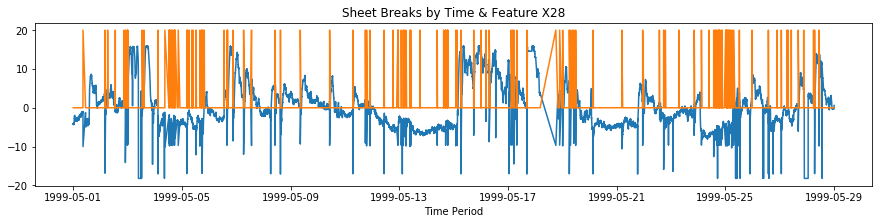

In [11]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x3'])
plt.plot(df['time'], df['y']*20)
plt.title("Sheet Breaks by Time & Feature X28")
plt.xlabel('Time Period')
plt.show()

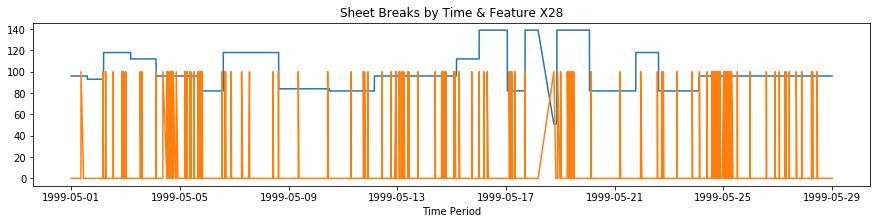

In [12]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x28'])
plt.plot(df['time'], df['y']*100)
plt.title("Sheet Breaks by Time & Feature X28")
plt.xlabel('Time Period')
plt.show()

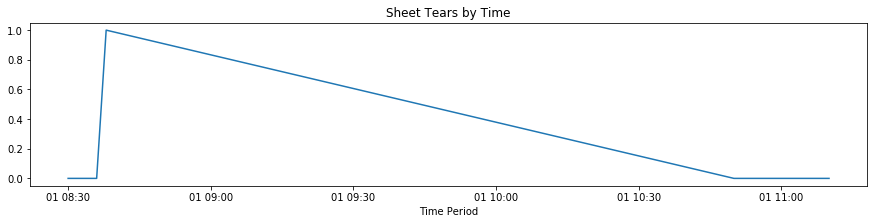

In [13]:
plt.figure(figsize=(15,3))
plt.plot(df['time'].loc[30*8.5:30*9], df['y'].loc[30*8.5:30*9])
plt.title("Sheet Tears by Time")
plt.xlabel('Time Period')
plt.show()

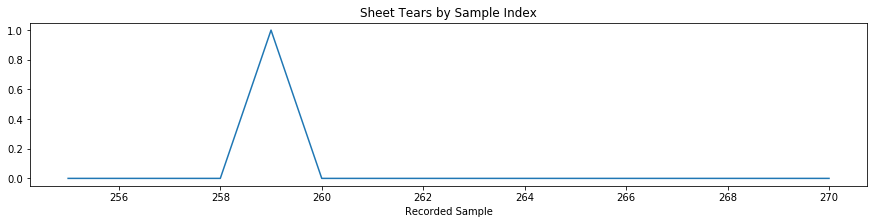

In [14]:
plt.figure(figsize=(15,3))
plt.plot(df['y'].loc[30*8.5:30*9])
plt.title("Sheet Tears by Sample Index")
plt.xlabel('Recorded Sample')
plt.show()

#### Feature x61

In [15]:
print('x61 unique values')
df['x61'].unique()

x61 unique values


array([0, 1], dtype=int64)

In [16]:
print('x61 value counts')
df['x61'].value_counts()

x61 value counts


0    18379
1       19
Name: x61, dtype: int64

In [17]:
print('"y" values when x61 is equal to 1')
df['y'][df['x61']==1].value_counts()

"y" values when x61 is equal to 1


1    19
Name: y, dtype: int64

Feature x61 is only 1 when y is 1, but only in 19 samples.  This may be a manual shutdown flag.  This can be seen in the chart below where the value of x61 is multiplied by 2 to be visible amoung the y values of 1 

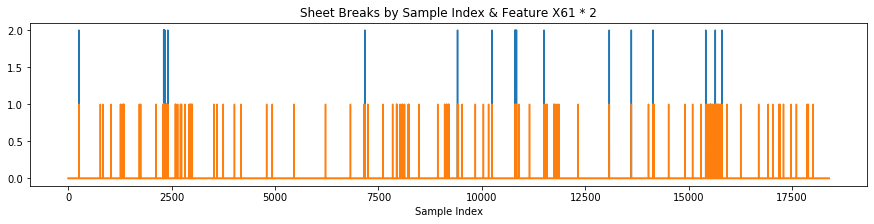

In [18]:
plt.figure(figsize=(15,3))
#plt.plot(df['time'], df['x61']*2)
#plt.plot(df['time'], df['y'])
plt.plot( df['x61']*2)
plt.plot( df['y'])
plt.title("Sheet Breaks by Sample Index & Feature X61 * 2")
plt.xlabel('Sample Index')
#plt.xlim(250,1000)
plt.show()

#### Feature Distributions:
The feature distributions for y=0 and y=1 and shown below.

Some features are fairly well aligned for normal and failure conditions like x5, x6, and x7 among others.  The outliers in these distributions may be related to pre-failure conditions.  
Some features show marked differences between normal and failure startes like x2, x3, an x29.  Again, outlier values may be assoicated with pre-failure conditions.
Some feature display mutliple peaks which may be associated with differences in feature x28, such as features xx21, x23, x33, x44, and x52.
Some features exhibit very narrow peaks with wide tails.  These may have a categorical nature although with a float value.

These will be examined with correlation mapping on feature subsets and looking at the features with box plots focussing on pre-failure and failure samples.

In [19]:
process_features = df.columns[2:62]

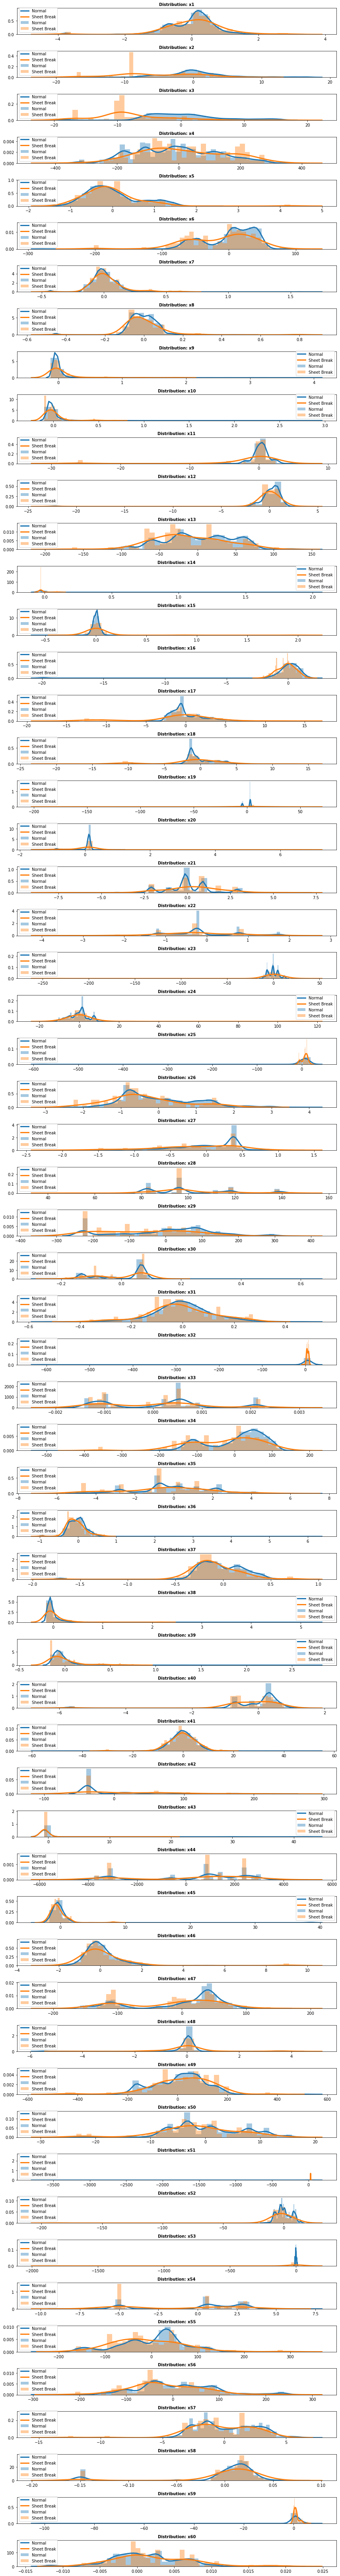

In [20]:
process_features = df.columns[2:62]
plt.figure(figsize=(12,60*1.5))
gs = gridspec.GridSpec(60, 1)

for  i, col_val in enumerate(process_features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[col_val][df['y'] == 0], bins = 40, label = 'Normal',
                 kde_kws={"lw": 3, "label": "Normal"})
    sns.distplot(df[col_val][df['y'] == 1], bins = 40, label = 'Sheet Break',
                 kde_kws={"lw": 3, "label": "Sheet Break"})
    ax.set_title('Distribution: ' + col_val, weight = 'bold', fontsize = 10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('', fontsize = 12)
plt.tight_layout()

### Take a closer look at a few features 

#### Feature x51:   an odd distribution.
This feature shows a majority of values near +40, but with several samples less than -3000. (The first chart show x51 / 3000).

In [21]:
df['x51'].nunique(), min(df['x51']), max(df['x51'])

(2743, -3652.989, 40.1523482)

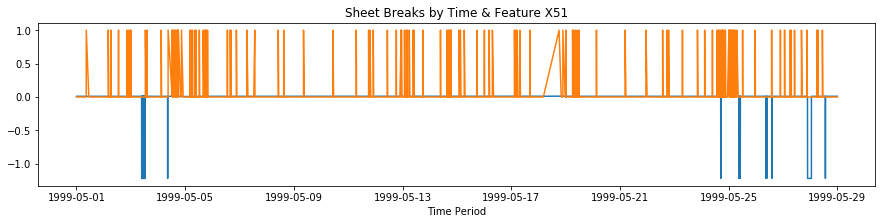

In [22]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x51']/3000)
plt.plot(df['time'], df['y'])
plt.title("Sheet Breaks by Time & Feature X51")
plt.xlabel('Time Period')
plt.show()

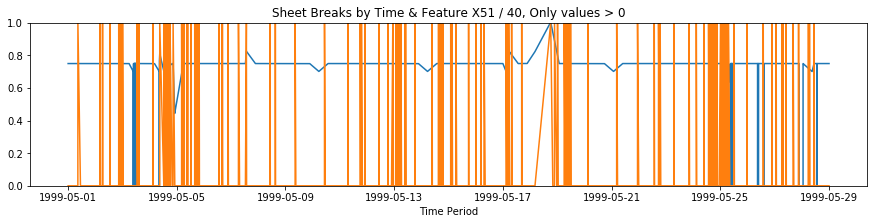

In [23]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x51']/40)
plt.plot(df['time'], df['y'])
plt.title("Sheet Breaks by Time & Feature X51 / 40, Only values > 0")
plt.xlabel('Time Period')
plt.ylim(0,1)
plt.show()

#### Feature x3: Often shows a decline after startup, sometimes ending in a sheet break.

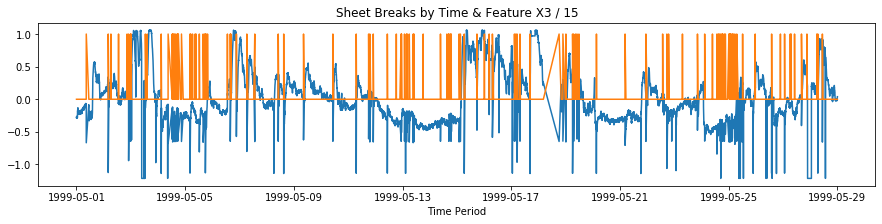

In [24]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x3']/15)

plt.plot(df['time'], df['y'])
#plt.plot(df['time'], df['x12']*10)
plt.title("Sheet Breaks by Time & Feature X3 / 15")
plt.xlabel('Time Period')
plt.show()

#### Feature x53:  There may be a correlation with x28.

In [25]:
df['x53'].nunique(), min(df['x53']), max(df['x53']), len(df[df['x53']<-15])

(10938, -1817.5955, 11.1480061, 1)

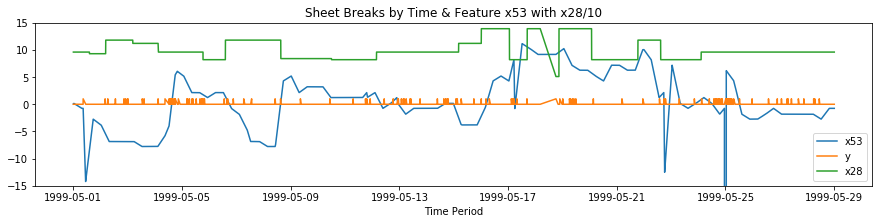

In [26]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x53'], label = 'x53')
plt.plot(df['time'], df['y'], label = 'y')
plt.plot(df['time'], df['x28']/10, label = 'x28')
plt.title("Sheet Breaks by Time & Feature x53 with x28/10")
plt.xlabel('Time Period')
plt.legend()
plt.ylim(-15,15)
plt.show()

#### Feature x52:  There appears to be a correlation with x28.  The x52 values seem to be in blocks aligning with x28 changes.

In [27]:
df['x52'].nunique(), min(df['x52']), max(df['x52']), len(df[df['x52']<-15])

(11257, -187.94343999999998, 14.1805884, 31)

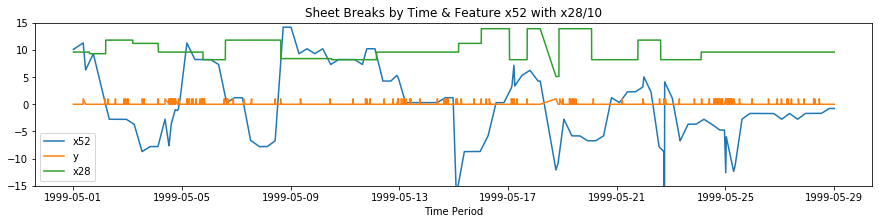

In [28]:
plt.figure(figsize=(15,3))
plt.plot(df['time'], df['x52'], label = 'x52')
plt.plot(df['time'], df['y'], label = 'y')
plt.plot(df['time'], df['x28']/10, label = 'x28')
plt.title("Sheet Breaks by Time & Feature x52 with x28/10")
plt.xlabel('Time Period')
plt.legend()
plt.ylim(-15,15)
plt.show()

### Add labels  1,2,3,4,5 for pre-failure time series: 1 for 5 time increments before the failure, 5 for one time increment before the failure.

In [29]:
breaks = df['y'][df['y']==1].index
df['label'] = 0
for ind in breaks:
    for i in range(6):
        if df['label'][ind - i] == 0:  # avoid relabelling samples from a prior sheet break if they are closer than 6 samples apart
            df['label'][ind - i] = 6 - i 

df['label'][252:261]

252    0
253    0
254    1
255    2
256    3
257    4
258    5
259    6
260    0
Name: label, dtype: int64

In [30]:
df['label'].value_counts()

0    17673
6      124
5      124
4      123
3      122
2      119
1      113
Name: label, dtype: int64

In [31]:
process_features = df.columns[2:62]
df_stats = pd.DataFrame(columns = process_features)
df_stats = df[process_features].describe()
df_stats

x1            x2            x3            x4            x5  \
count  18398.000000  18398.000000  18398.000000  18398.000000  18398.000000   
mean       0.011824      0.157986      0.569300     -9.958345      0.006518   
std        0.742875      4.939762      5.937178    131.033712      0.634054   
min       -3.787279    -17.316550    -18.198509   -322.781610     -1.623988   
25%       -0.405681     -2.158235     -3.537054   -111.378372     -0.446787   
50%        0.128245     -0.075505     -0.190683    -14.881585     -0.120745   
75%        0.421222      2.319297      3.421223     92.199134      0.325152   
max        3.054156     16.742105     15.900116    334.694098      4.239385   

                 x6            x7            x8            x9           x10  \
count  18398.000000  18398.000000  18398.000000  18398.000000  18398.000000   
mean       2.387533      0.001647     -0.004125     -0.003056     -0.002511   
std       37.104012      0.108870      0.075460      0.156047      0.106526   
min     -279.408440     -0.429273     -0.451141     -0.120087     -0.098310   
25%      -24.345268     -0.058520     -0.051043     -0.059966     -0.048260   
50%       10.528435     -0.009339     -0.000993     -0.030057     -0.018352   
75%       32.172974      0.060515      0.038986      0.001990      0.011557   
max       96.060768      1.705590      0.788826      4.060033      2.921802   

       ...           x51           x52           x53           x54  \
count  ...  18398.000000  18398.000000  18398.000000  18398.000000   
mean   ...     -3.357339      0.380519      0.360246      0.173708   
std    ...    348.256716      6.211598     14.174273      3.029516   
min    ...  -3652.989000   -187.943440  -1817.595500     -8.210370   
25%    ...     29.984624     -3.672684     -1.928166      0.487780   
50%    ...     29.984624      0.294846      0.143612      0.702299   
75%    ...     29.984624      5.109543      3.230770      2.675751   
max    ...     40.152348     14.180588     11.148006      6.637265   

                x55           x56           x57           x58           x59  \
count  18398.000000  18398.000000  18398.000000  18398.000000  18398.000000   
mean       2.379154      9.234953      0.233493     -0.001861     -0.061522   
std       67.940694     81.274103      2.326838      0.048732     10.394085   
min     -230.574030   -269.039500    -12.640370     -0.149790   -100.810500   
25%      -40.050046    -45.519149     -1.598804      0.000470      0.295023   
50%       17.471317      1.438806      0.085826      0.012888      0.734591   
75%       44.093387     63.209681      2.222118      0.020991      1.266506   
max      287.252017    252.147455      6.922008      0.067249      6.985460   

                x60  
count  18398.000000  
mean       0.001258  
std        0.004721  
min       -0.012229  
25%       -0.001805  
50%        0.000710  
75%        0.004087  
max        0.020510  

[8 rows x 60 columns]

### Run a preliminary Random Forest model to screen feature importance.  This is not intended to be a final model.
Run with all samples features and again with a balanced set using fewer '0' labels 

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df[process_features], df['label'], stratify = df['label'], random_state =10)

In [34]:
X_train.shape, X_test.shape

((13798, 60), (4600, 60))

In [35]:
model = RandomForestClassifier(n_estimators = 100, max_depth = 20, random_state = 10)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [36]:
F_I = model.feature_importances_

In [37]:
# Get an undersample dataset
from sklearn.utils import shuffle

normals = df[df['label'] == 0].sample(n = 124)
labeled = df[df['label'] != 0]
df_under = pd.merge(normals, labeled, how = 'outer')
df_under = shuffle(df_under)
df_under['label'].value_counts()

6    124
5    124
0    124
4    123
3    122
2    119
1    113
Name: label, dtype: int64

#### Re-run a RF Classifier on the balanced / undersampled dataset

In [38]:
XU_train, XU_test, yu_train, yu_test = train_test_split(df_under[process_features], df_under['label'], stratify = df_under['label'], random_state =10)

In [39]:
XU_train.shape, XU_test.shape

((636, 60), (213, 60))

In [40]:
modelU = RandomForestClassifier(n_estimators = 100, max_depth = 20, random_state = 10)
modelU.fit(XU_train, yu_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [41]:
yu_pred = modelU.predict(XU_test)

In [42]:
cm_u = confusion_matrix(yu_test, yu_pred)
cm_u

array([[21,  1,  2,  1,  0,  4,  2],
       [ 0,  0, 15,  7,  3,  3,  0],
       [ 0, 17,  0,  6,  6,  1,  0],
       [ 1,  5, 10,  0, 12,  2,  1],
       [ 0,  4,  6, 12,  0,  9,  0],
       [ 1,  4,  3,  7, 11,  0,  5],
       [ 1,  0,  0,  1,  2,  2, 25]], dtype=int64)

The confusion matrix lacks accuracy for labels 1 through5, however they are mislabeled within class 1 to 5 more than classified as either 0 or 6, indicating possibly some difference or transition between normal run state and at a sheet break.

In [43]:
F_IU = modelU.feature_importances_

#### Plot the feature importance with all samples and with an undersampled set using the 'label' feature as target. 

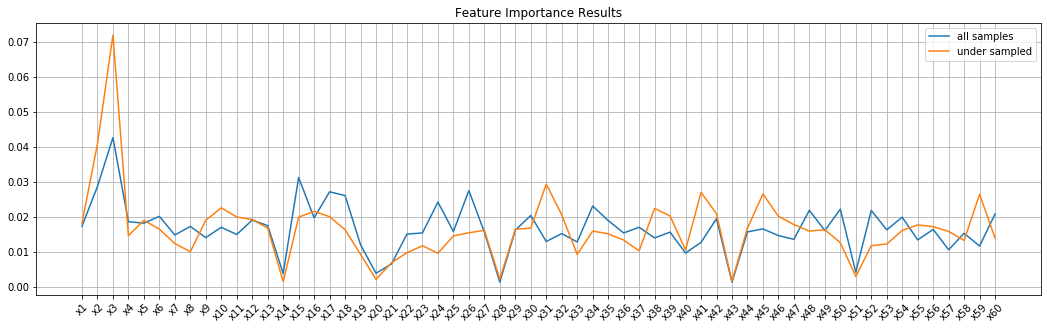

In [44]:
plt.figure(figsize=(18,5))
plt.plot(process_features,F_I, label = 'all samples')
plt.plot(process_features,F_IU, label = 'under sampled')
plt.title('Feature Importance Results')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Lowest importance features are consistent: x8, x14, x19, x20, x21, x28, x33, x43, x51

In [45]:
df.columns

Index(['time', 'y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60', 'x61', 'label'],
      dtype='object')

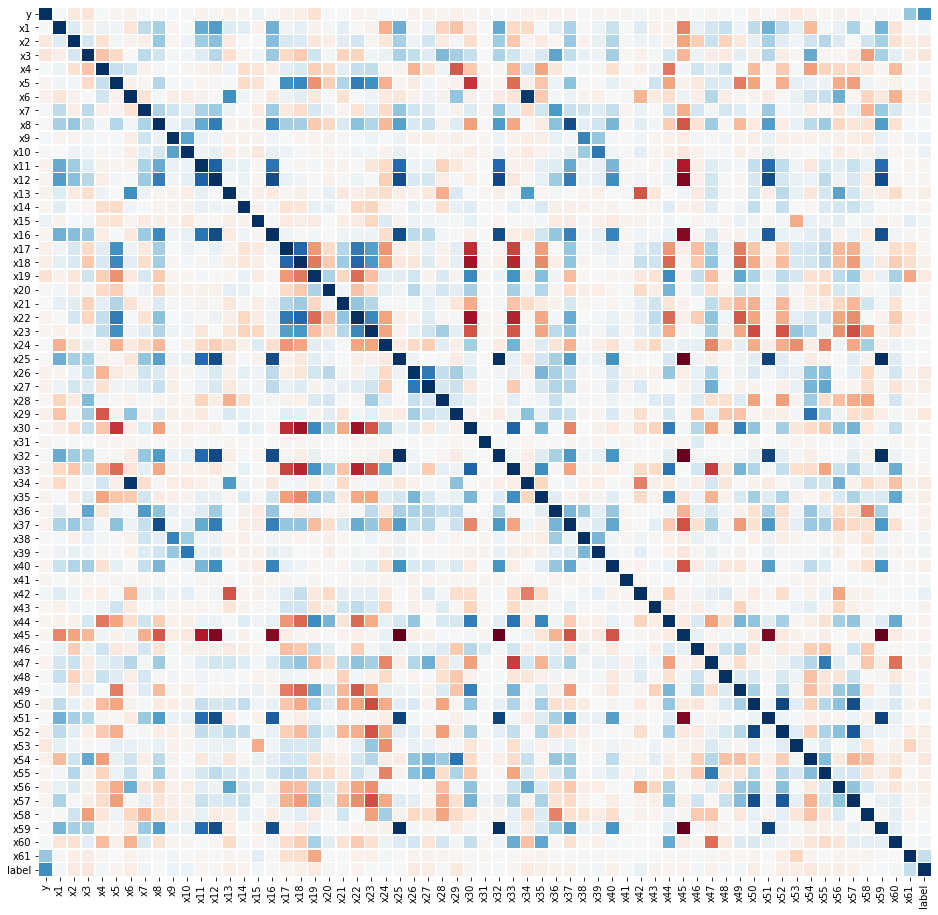

In [46]:
plt.figure(figsize=(16,16))
sns.heatmap(df[df.columns[1:64]].corr(), cmap='RdBu', cbar=False, linewidths=0.5)
plt.show()

The correlations in the heatmap above will be dominated by the normal operating states. Of interest are high ranked feature-importance features using all samples such as x2,x3,x4 and x15-x18, x24, x26, x34, x48, x50 & x52 have a medium correlation with some but not all features and a strong correlation with a few features.

#### Now look at a heat map of the undersampled / balanced dataset with roughly equal number of samples from the labels 0 through 6 where 0 is normal, 6 is a sheet break and 1-5 anre the preceding 5 time samples.

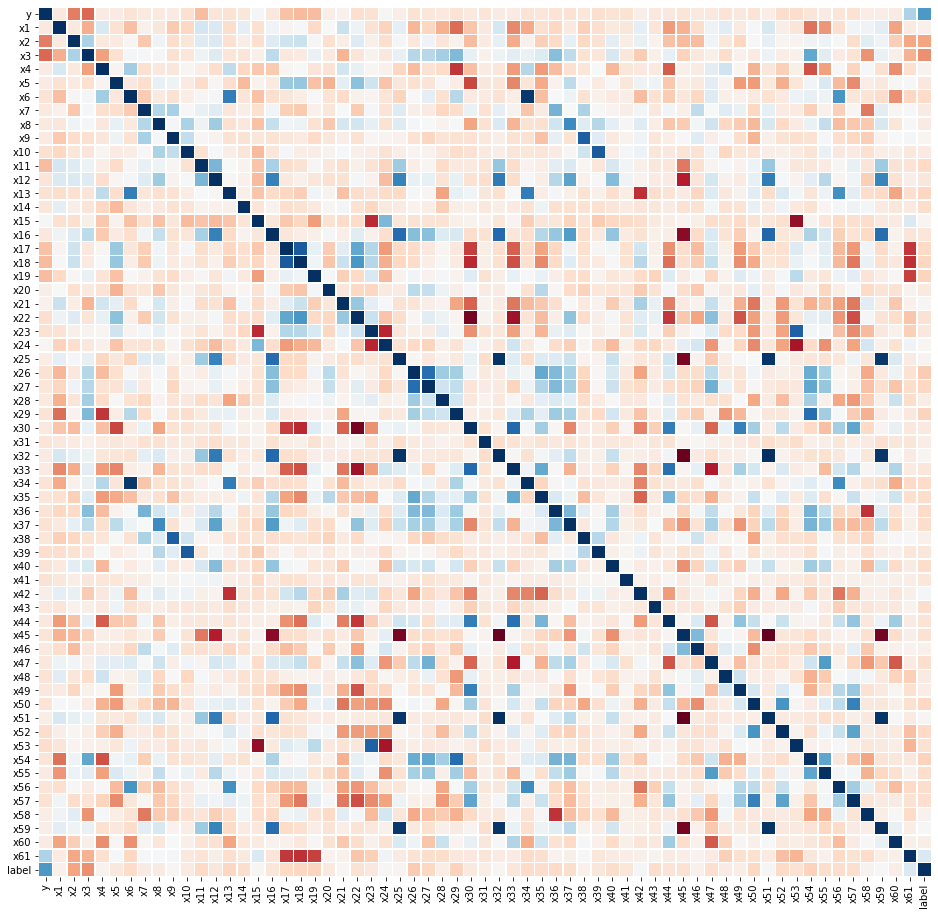

In [47]:
plt.figure(figsize=(16,16))
sns.heatmap(df_under[df.columns[1:64]].corr(), cmap='RdBu', cbar=False, linewidths=0.5)
plt.show()

Looking at the undersampled high ranking features from feature-importance x2, x3, x9-x13, x31, x41, x42, x44-x47, and x59, we see a medium to strong correlation between x2, x3 and label while the others are medium to weak with x31 and x41 showing a weak correlation with most other features.  x61 has a medium correlation but should be ignored as it has values of 1, 19 times and 0 for all other samples. 

### Now look at select features  (x22, x23, x28, x35, x53) that appear have multiple frequency peaks from the distribution plots which may indicate several different normal operating condition regions (the values vary around different local frequency maximums depending on the operating state).  Also look at the pre-failure samples.  

The upper two plots (below) show thre are interesting correlations between feature x22 with x23 and x35 with y=0 showing hard edges and blocks of operating regions that likely driven by the categorical feature x28.   These regions are not present when y=1.
The lower two plots show some separation of values with feature x28.
Some plots are skewed by outliers.

The charts that follow the pairplots dive deeper into these operating zones and look at the pre-failure samples (label = 1 to 5, with y=1 as 6) to see if these are on the edge of the operating envelope.

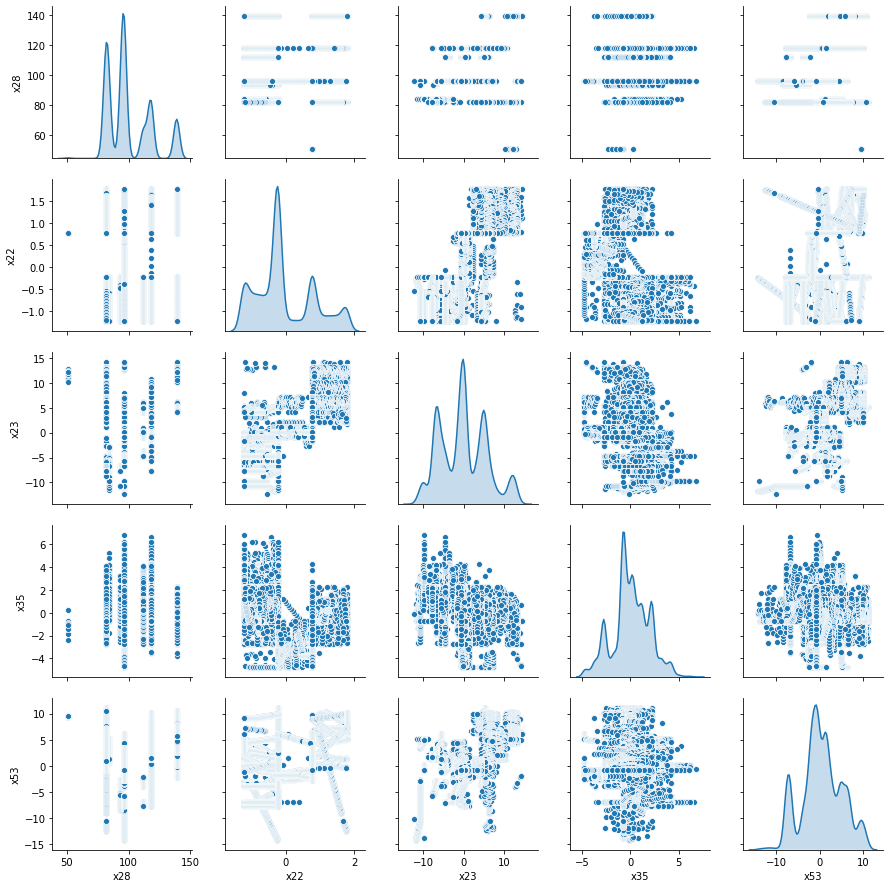

In [48]:
df_plot = df[['x28', 'x22', 'x23', 'x35', 'x53']][df['y']==0]
sns.pairplot(df_plot, diag_kind = "kde",kind = "scatter")
plt.show()

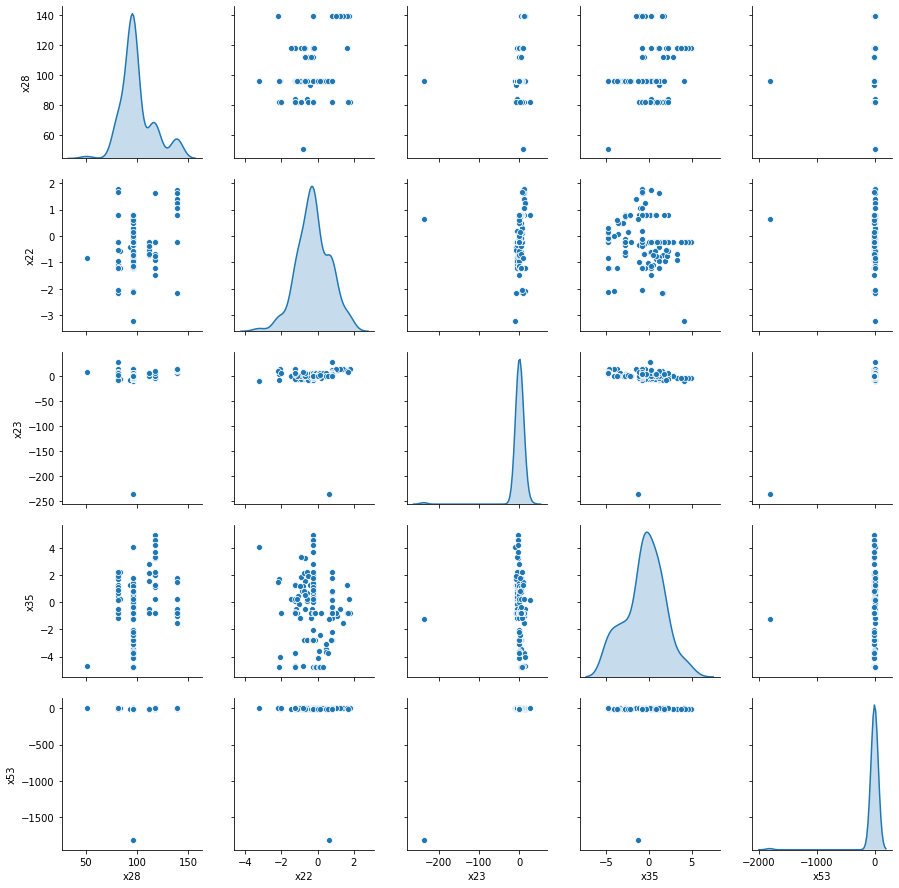

In [49]:
df_plot_1 = df[['x28', 'x22', 'x23', 'x35', 'x53']][df['y']==1]
sns.pairplot(df_plot_1, diag_kind = "kde",kind = "scatter")
plt.show()

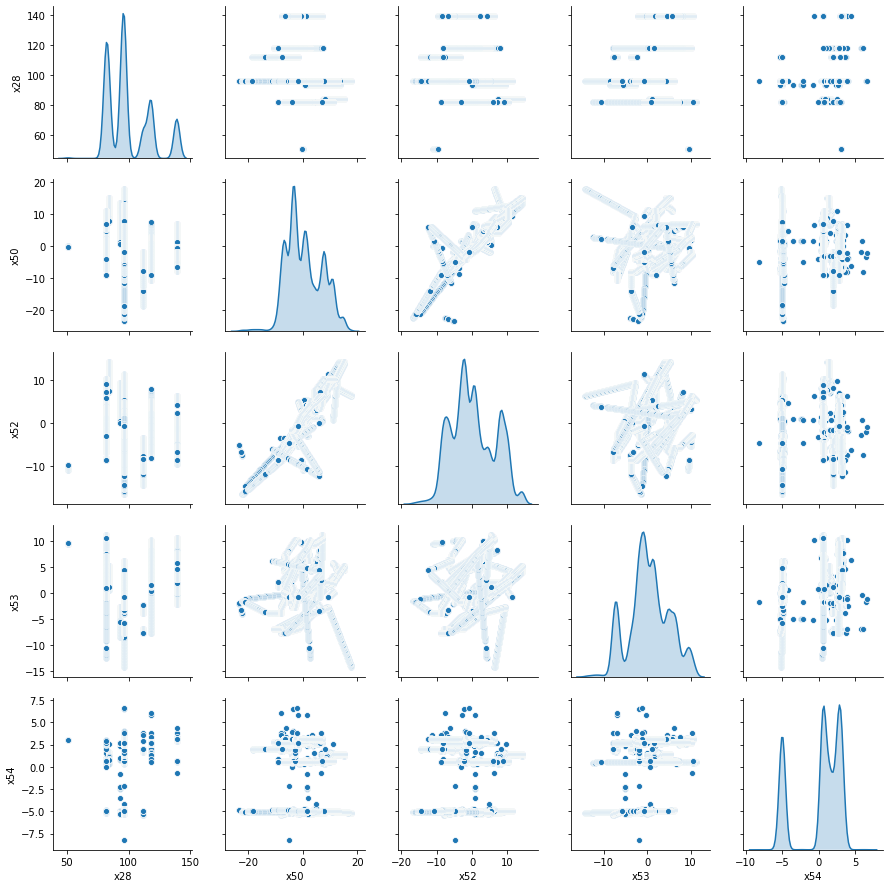

In [50]:
df_plot_2 = df[['x28', 'x50', 'x52', 'x53', 'x54']][df['y']==0]
sns.pairplot(df_plot_2, diag_kind = "kde",kind = "scatter")
plt.show()

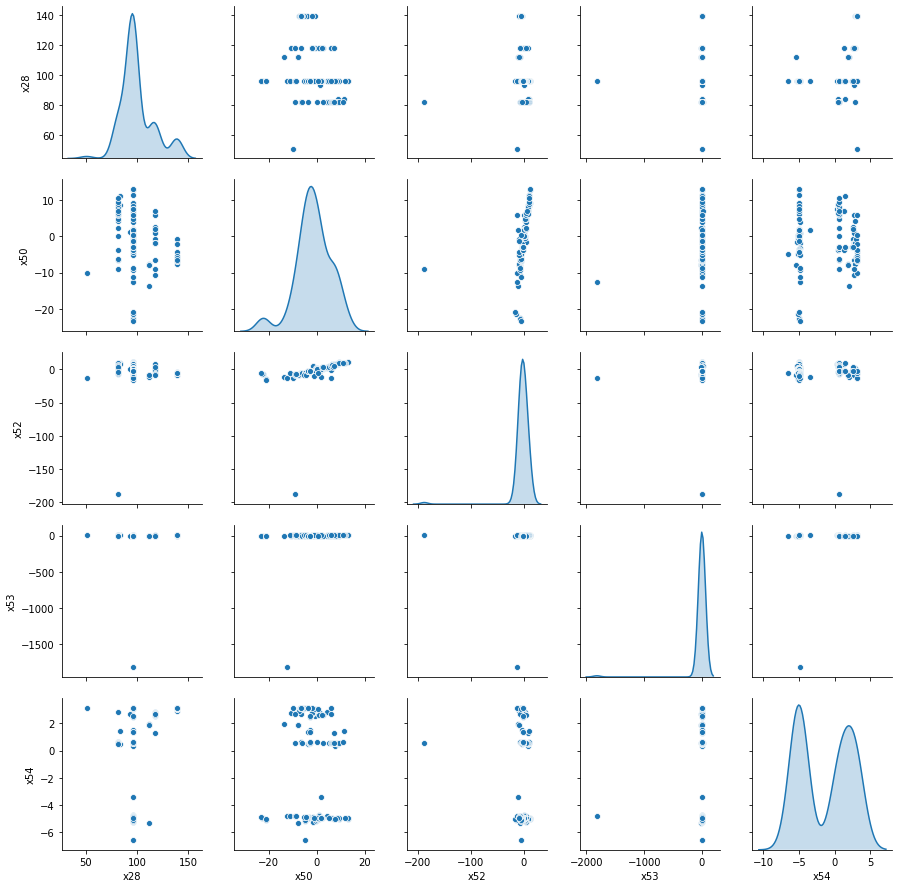

In [51]:
df_plot_3 = df[['x28', 'x50', 'x52', 'x53', 'x54']][df['y']==1]
sns.pairplot(df_plot_3, diag_kind = "kde",kind = "scatter")
plt.show()

#### Look at the operating region for x3 (which is the highest on Random Forest feature impoprtance) and x23
Visualise with feature x22 and the label value

In [52]:
def RelPlot(x_, y_, df, hue_, title_):
    g=sns.relplot(x = x_, y = y_, data = df , hue = hue_)
    g.fig.suptitle(title_, y=1.03, fontsize = 12)
    return g

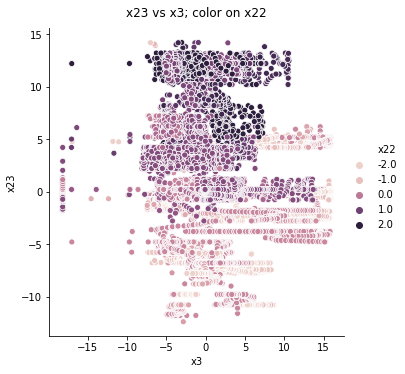

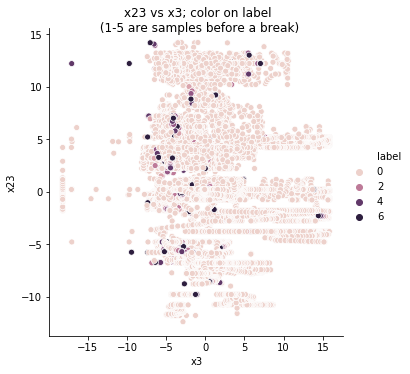

In [53]:
hues, titles =['x22', 'label'], ["x23 vs x3; color on x22", "x23 vs x3; color on label\n (1-5 are samples before a break)"]
for i in [0,1]:
    (RelPlot('x3', 'x23', df[df['y']==0], hues[i], titles[i]) )
plt.show()

#### Now slice the region up based on the categorical feature x28 coloring by x22 and label.
The samples just pror to the paper breaks are concentrated more than the overall operating region and vary depending on the values of x22 and x28.

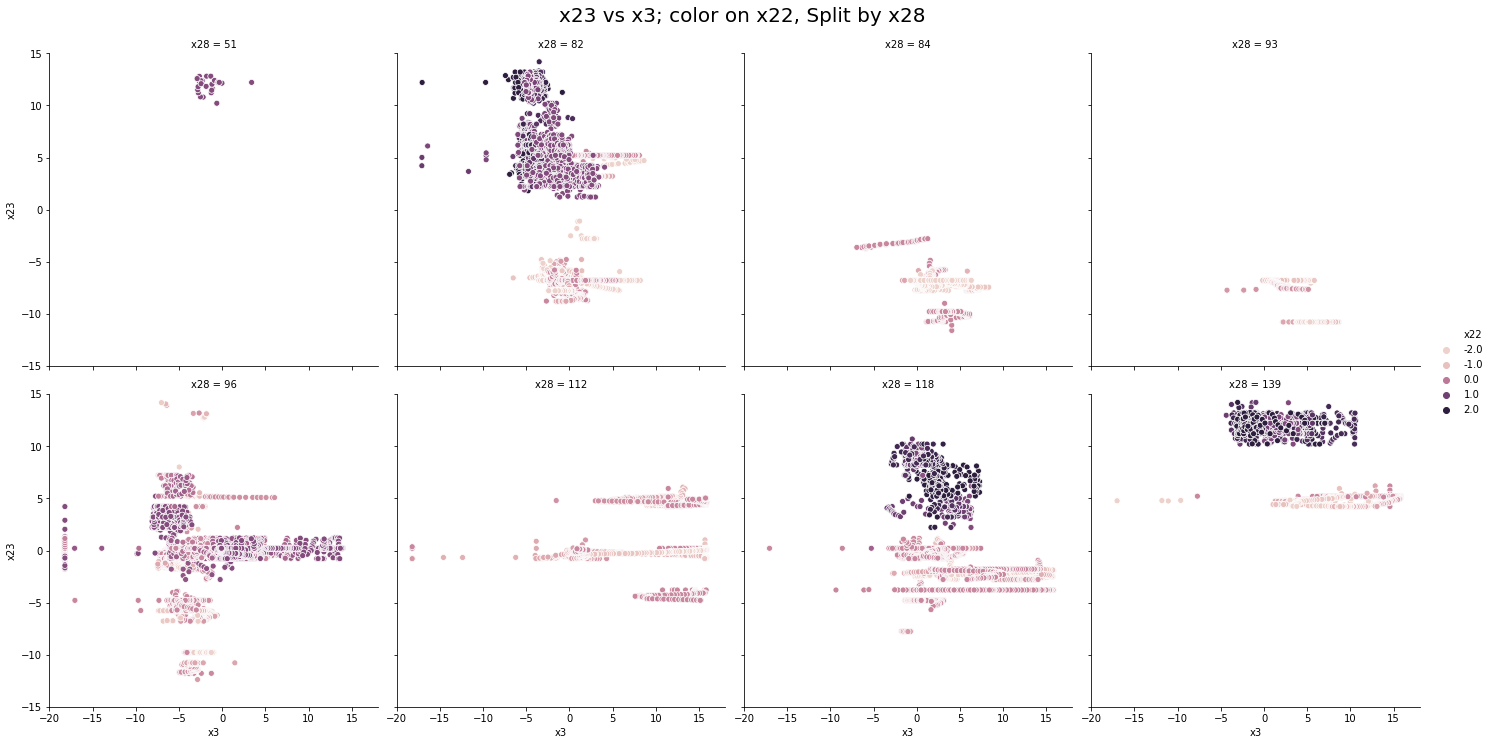

In [54]:
g=sns.relplot(x = 'x3', y = 'x23', data = df[df['y']==0] , hue = 'x22', col = 'x28', col_wrap = 4)
plt.xlim(-20,18), plt.ylim(-15,15)
g.fig.suptitle("x23 vs x3; color on x22, Split by x28", y=1.03, fontsize = 20)
plt.show()

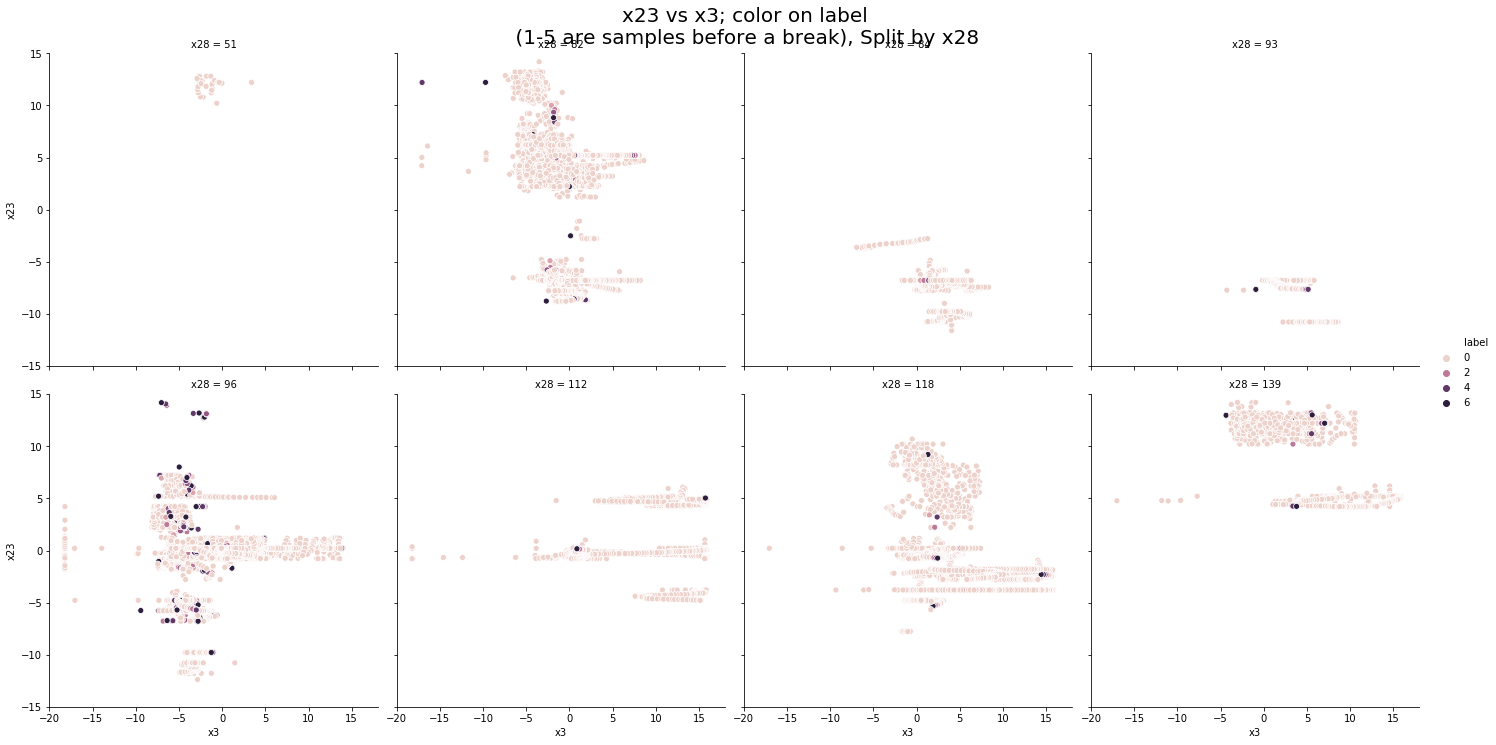

In [55]:
g=sns.relplot(x = 'x3', y = 'x23', data = df[df['y']==0] , hue = 'label', col = 'x28', col_wrap = 4)
plt.xlim(-20,18), plt.ylim(-15,15)
g.fig.suptitle("x23 vs x3; color on label\n (1-5 are samples before a break), Split by x28", y=1.03, fontsize = 20)
plt.show()

### Now repeat with x35 and x52 relative to x22 and x28.

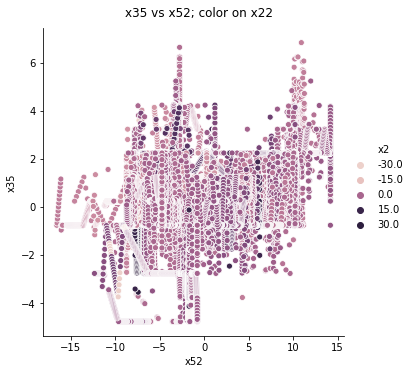

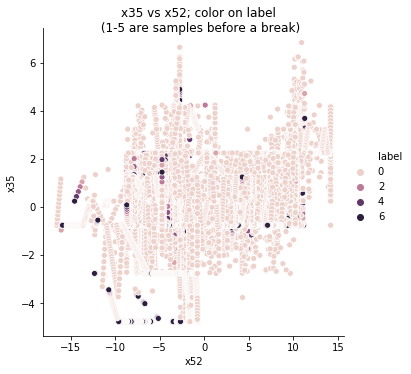

In [56]:
hues, titles =['x2', 'label'], ["x35 vs x52; color on x22", "x35 vs x52; color on label\n (1-5 are samples before a break)"]
for i in [0,1]:
    (RelPlot('x52', 'x35', df[df['y']==0], hues[i], titles[i]) )
plt.show()

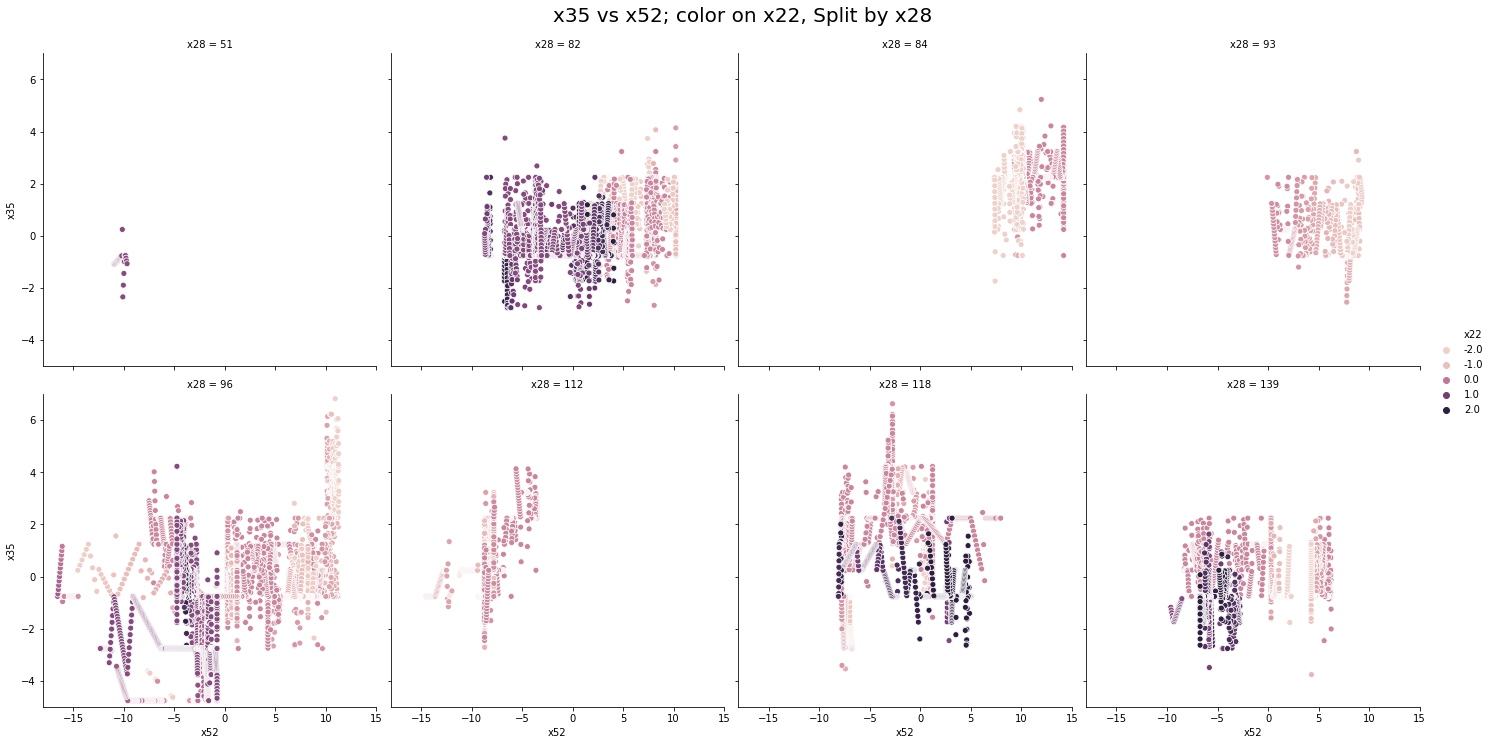

In [57]:
g=sns.relplot(x = 'x52', y = 'x35', data = df[df['y']==0] , hue = 'x22', col = 'x28', col_wrap = 4)
plt.xlim(-18,15), plt.ylim(-5,7)
g.fig.suptitle("x35 vs x52; color on x22, Split by x28", y=1.03, fontsize = 20)
plt.show()

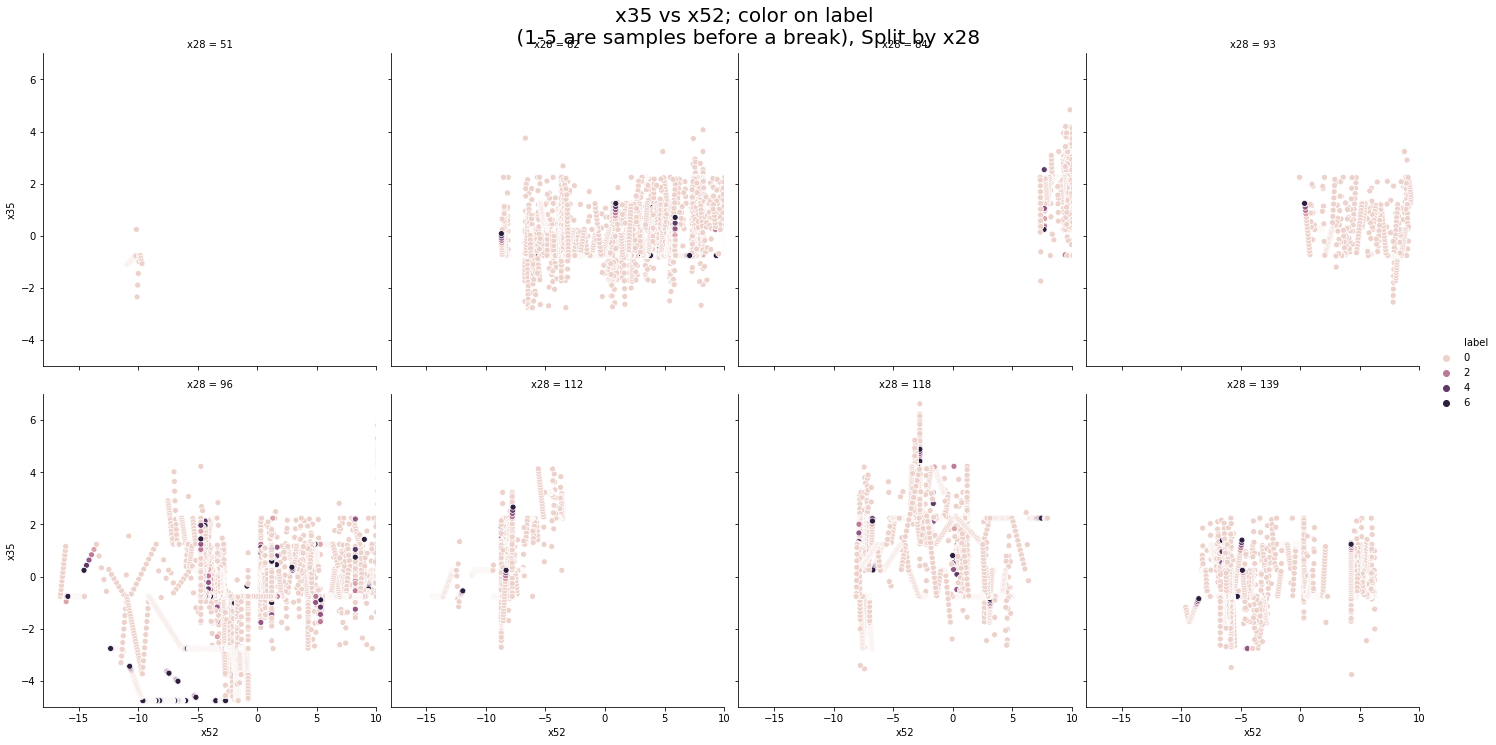

In [58]:
g=sns.relplot(x = 'x52', y = 'x35', data = df[df['y']==0] , hue = 'label', col = 'x28', col_wrap = 4)
plt.xlim(-18,10), plt.ylim(-5,7)
g.fig.suptitle("x35 vs x52; color on label\n (1-5 are samples before a break), Split by x28", y=1.03, fontsize = 20)
plt.show()

#### Now repeat with x35 and x54 relative to x22 and x28

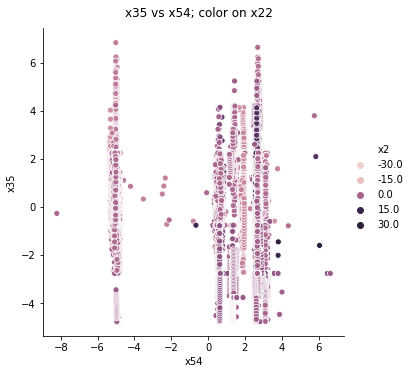

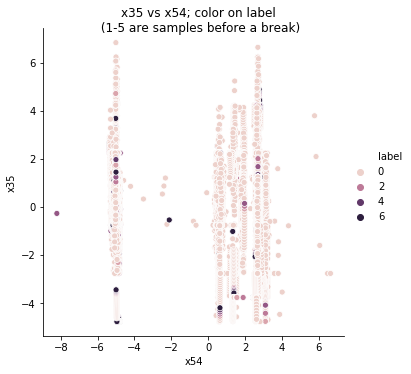

In [59]:
hues, titles =['x2', 'label'], ["x35 vs x54; color on x22", "x35 vs x54; color on label\n (1-5 are samples before a break)"]
for i in [0,1]:
    (RelPlot('x54', 'x35', df[df['y']==0], hues[i], titles[i]) )
plt.show()

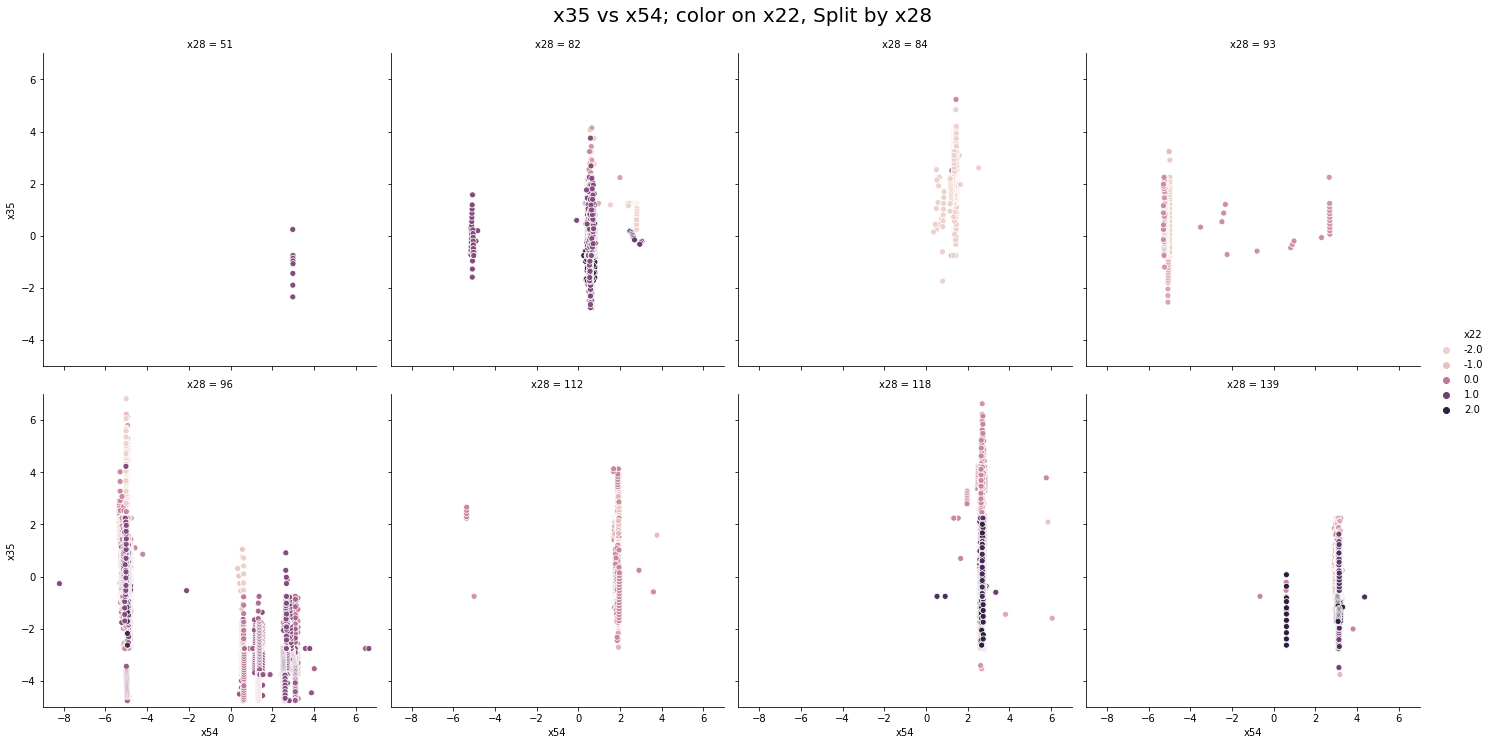

In [60]:
g=sns.relplot(x = 'x54', y = 'x35', data = df[df['y']==0] , hue = 'x22', col = 'x28', col_wrap = 4)
plt.xlim(-9,7), plt.ylim(-5,7)
g.fig.suptitle("x35 vs x54; color on x22, Split by x28", y=1.03, fontsize = 20)
plt.show()

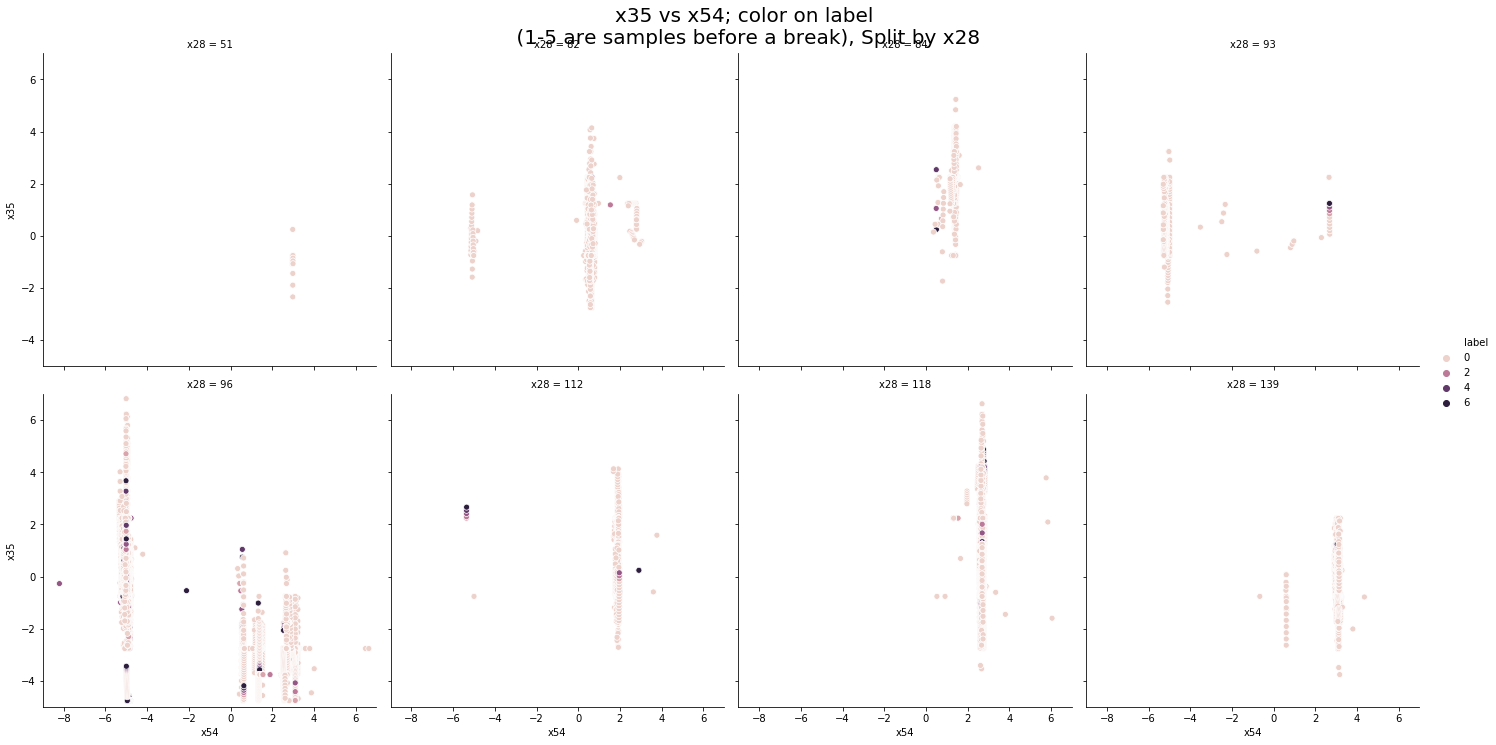

In [61]:
g=sns.relplot(x = 'x54', y = 'x35', data = df[df['y']==0] , hue = 'label', col = 'x28', col_wrap = 4)
plt.xlim(-9,7), plt.ylim(-5,7)
g.fig.suptitle("x35 vs x54; color on label\n (1-5 are samples before a break), Split by x28", y=1.03, fontsize = 20)
plt.show()

#### Repeat for x53 and x23.

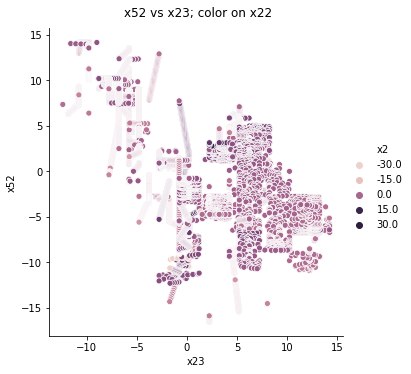

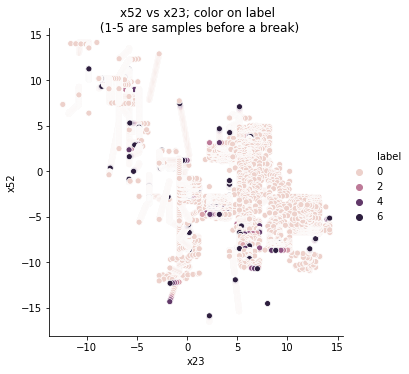

In [62]:
hues, titles =['x2', 'label'], ["x52 vs x23; color on x22", "x52 vs x23; color on label\n (1-5 are samples before a break)"]
for i in [0,1]:
    (RelPlot('x23', 'x52', df[df['y']==0], hues[i], titles[i]) )
plt.show()

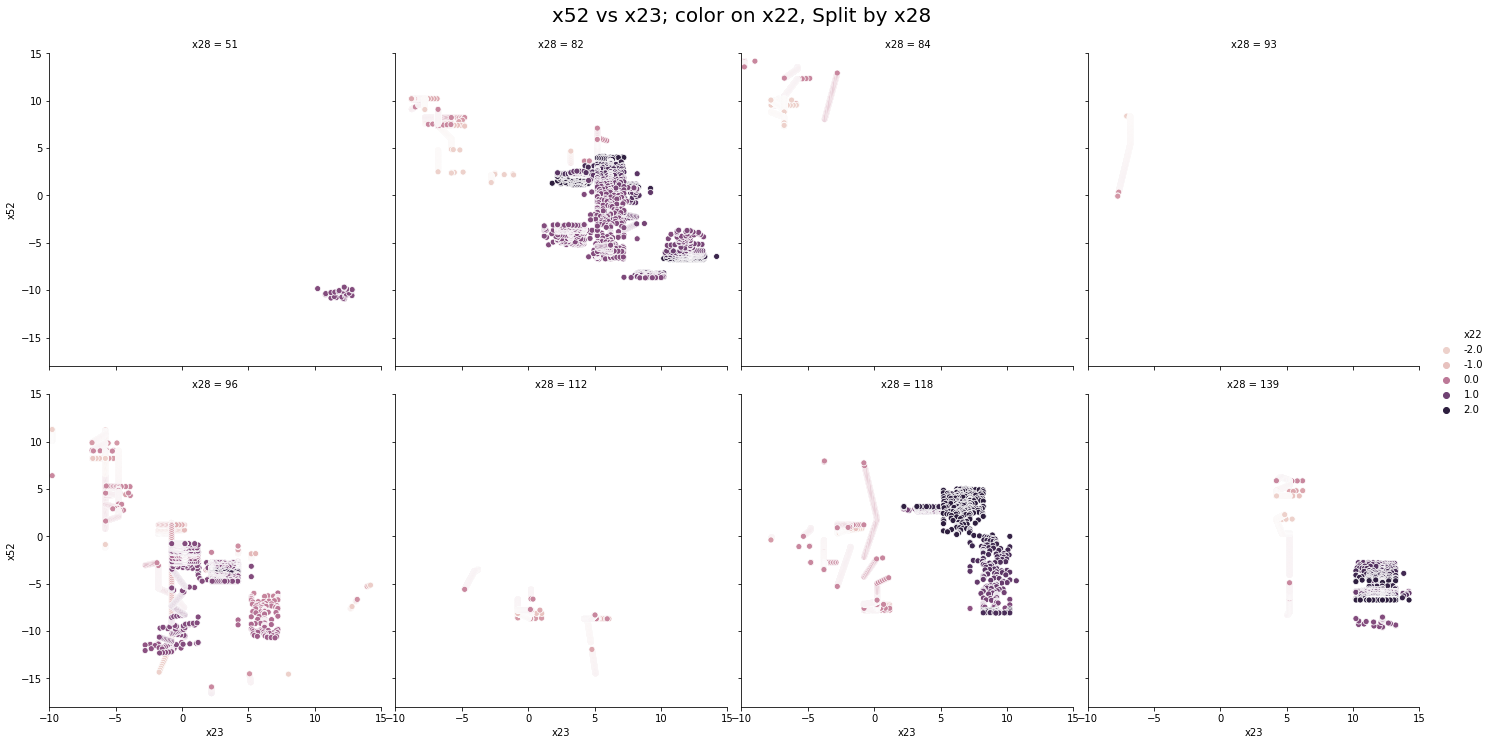

In [63]:
g=sns.relplot(x = 'x23', y = 'x52', data = df[df['y']==0] , hue = 'x22', col = 'x28', col_wrap = 4)
plt.xlim(-10,15), plt.ylim(-18,15)
g.fig.suptitle("x52 vs x23; color on x22, Split by x28", y=1.03, fontsize = 20)
plt.show()

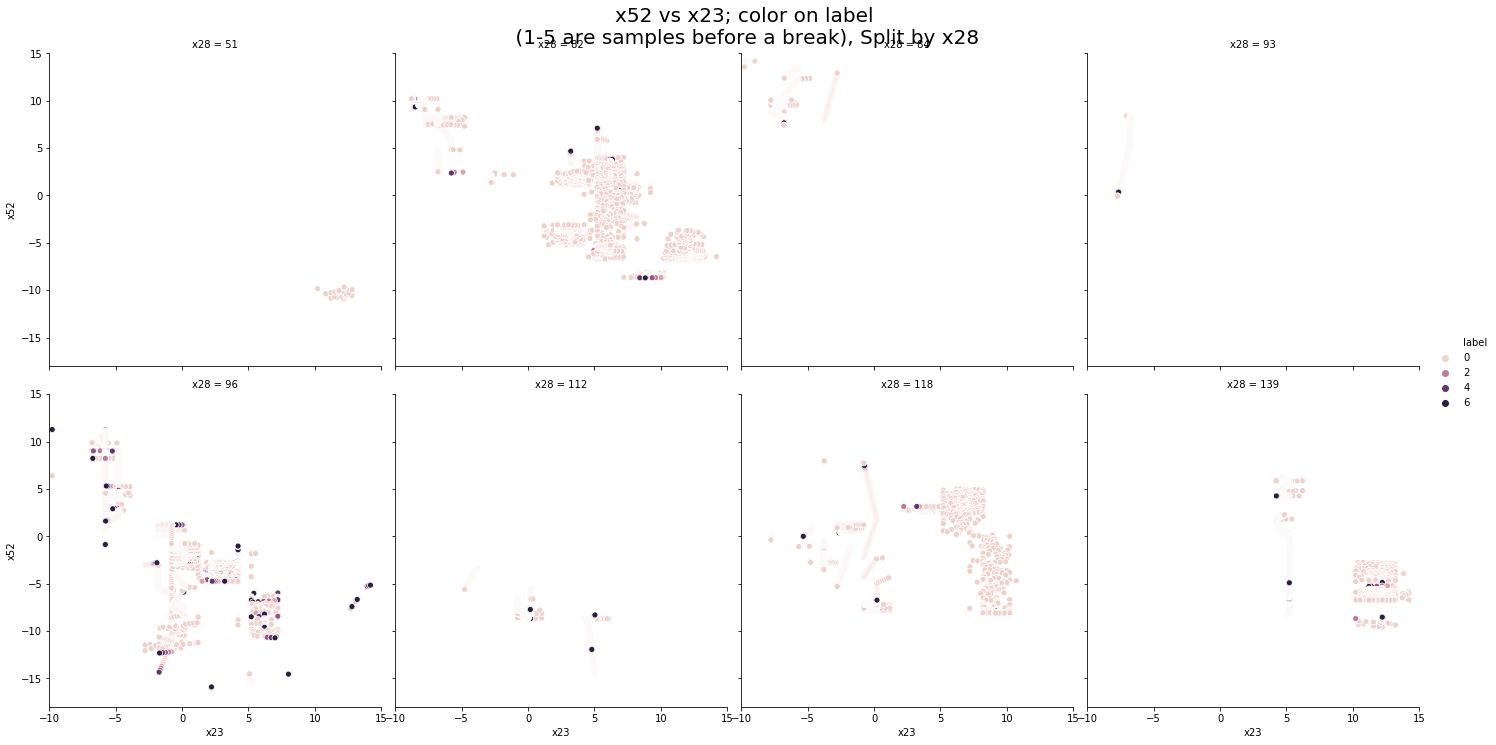

In [64]:
g=sns.relplot(x = 'x23', y = 'x52', data = df[df['y']==0] , hue = 'label', col = 'x28', col_wrap = 4)
plt.xlim(-10,15), plt.ylim(-18,15)
g.fig.suptitle("x52 vs x23; color on label\n (1-5 are samples before a break), Split by x28", y=1.03, fontsize = 20)
plt.show()

#### Repeat for x53 and x23.  THese two are strongly correlated on the undersampled heatmap.

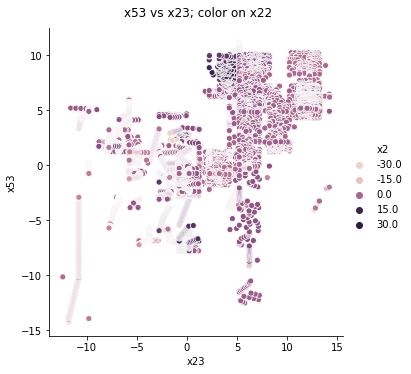

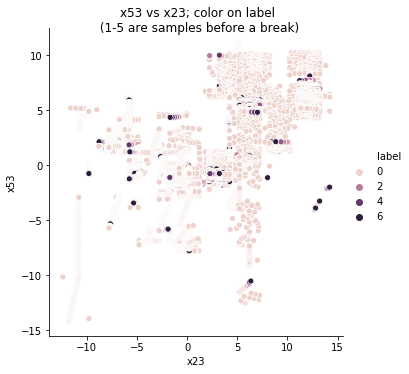

In [65]:
hues, titles =['x2', 'label'], ["x53 vs x23; color on x22", "x53 vs x23; color on label\n (1-5 are samples before a break)"]
for i in [0,1]:
    (RelPlot('x23', 'x53', df[df['y']==0], hues[i], titles[i]) )
plt.show()

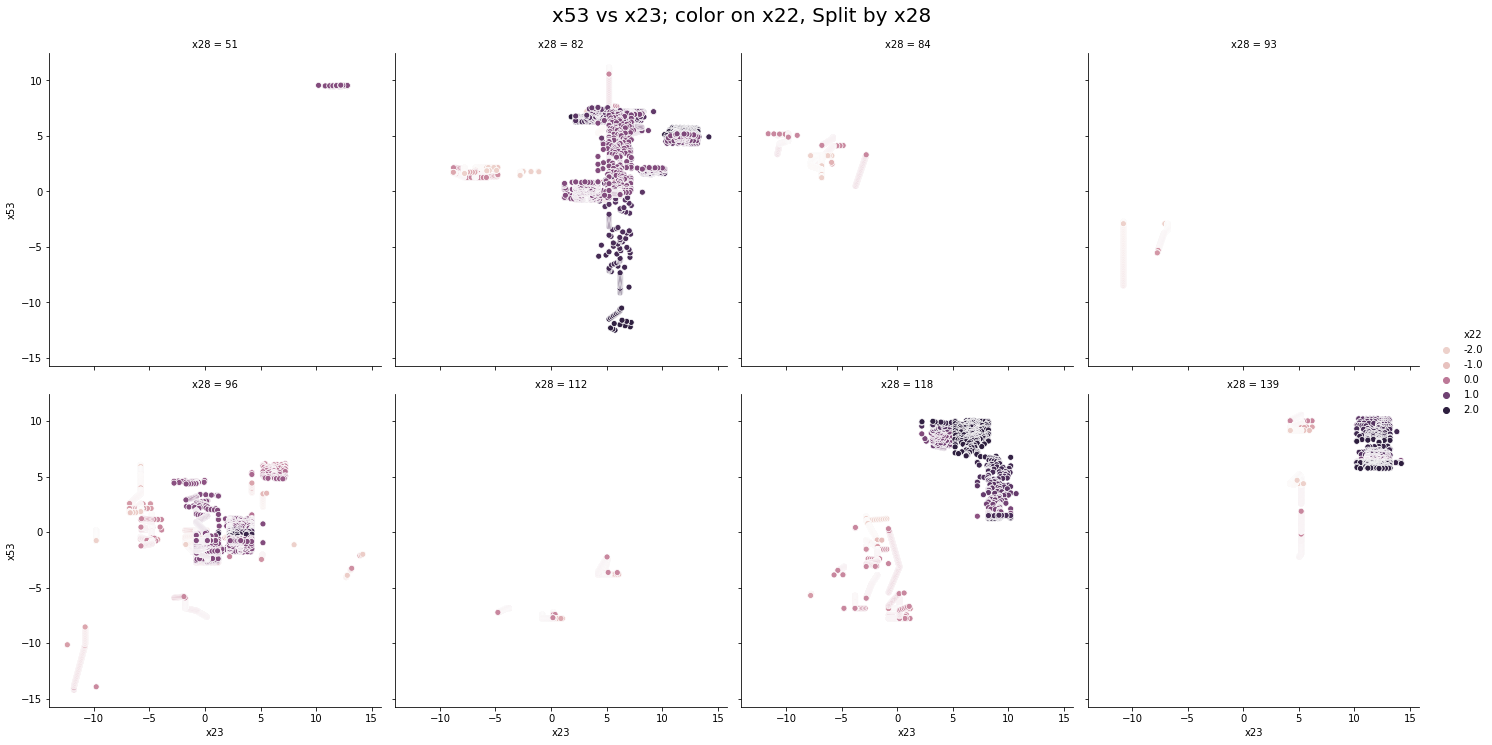

In [66]:
g=sns.relplot(x = 'x23', y = 'x53', data = df[df['y']==0] , hue = 'x22', col = 'x28', col_wrap = 4)
g.fig.suptitle("x53 vs x23; color on x22, Split by x28", y=1.03, fontsize = 20)
#plt.xlim(-10,15), plt.ylim(-15,15)
plt.show()

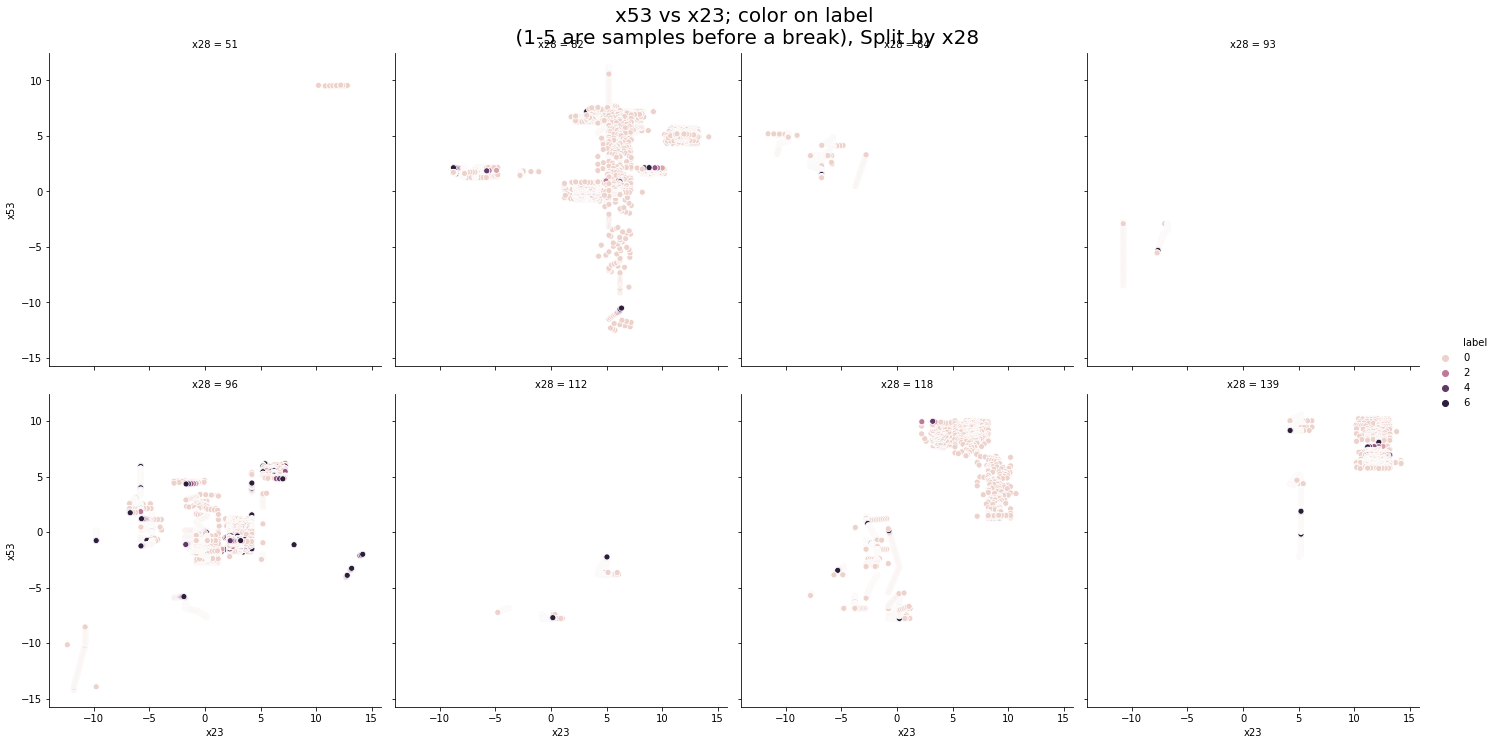

In [67]:
g=sns.relplot(x = 'x23', y = 'x53', data = df[df['y']==0] , hue = 'label', col = 'x28', col_wrap = 4)
g.fig.suptitle("x53 vs x23; color on label\n (1-5 are samples before a break), Split by x28", y=1.03, fontsize = 20)
#plt.xlim(-10,15), plt.ylim(-15,15)
plt.show()

#### Repeat for x35 and x23.

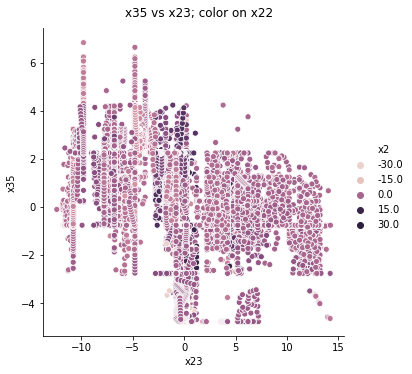

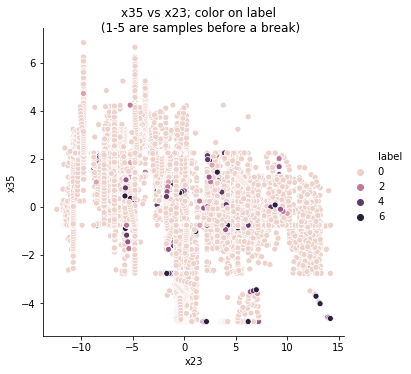

In [68]:
hues, titles =['x2', 'label'], ["x35 vs x23; color on x22", "x35 vs x23; color on label\n (1-5 are samples before a break)"]
for i in [0,1]:
    (RelPlot('x23', 'x35', df[df['y']==0], hues[i], titles[i]) )
plt.show()

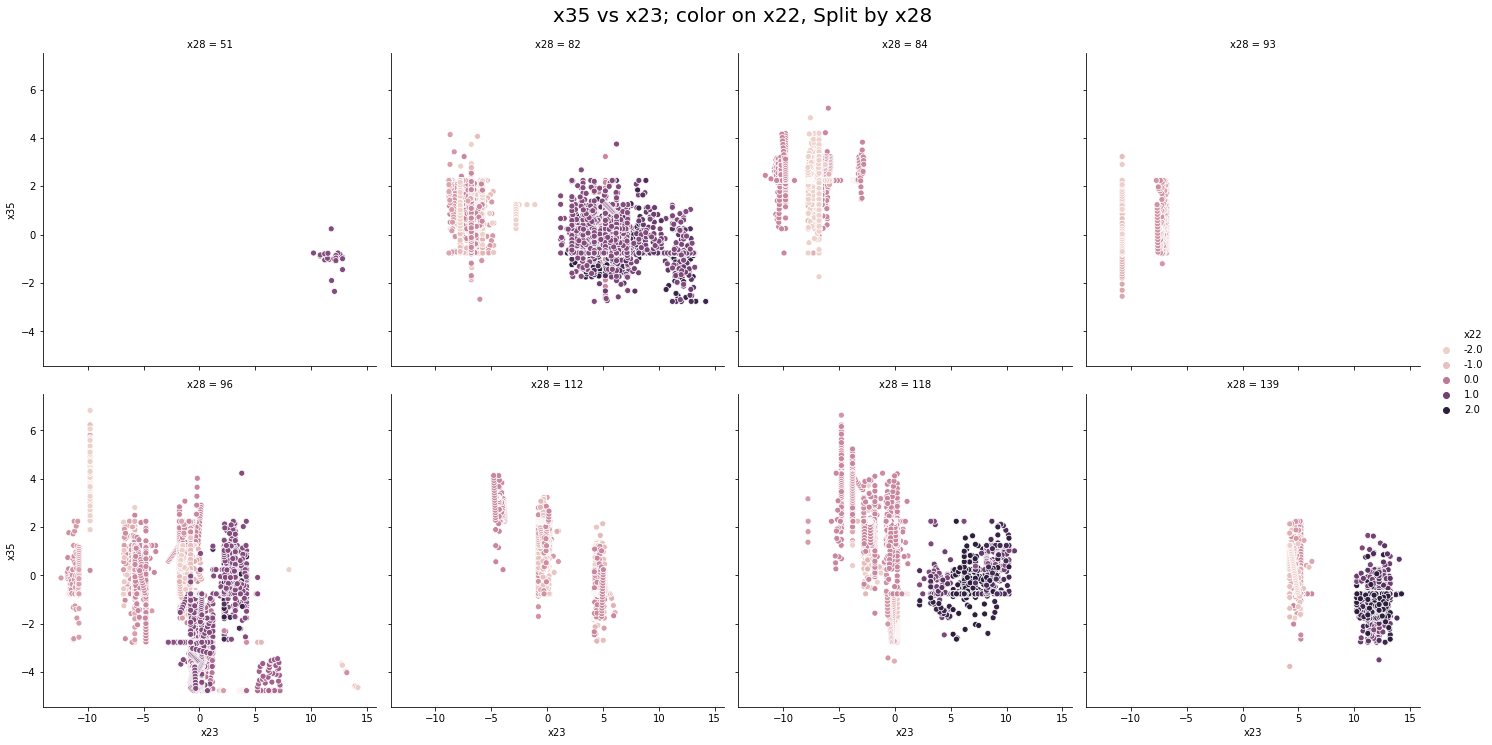

In [69]:
g=sns.relplot(x = 'x23', y = 'x35', data = df[df['y']==0] , hue = 'x22', col = 'x28', col_wrap = 4 )
g.fig.suptitle("x35 vs x23; color on x22, Split by x28", y=1.03, fontsize = 20)
plt.show()

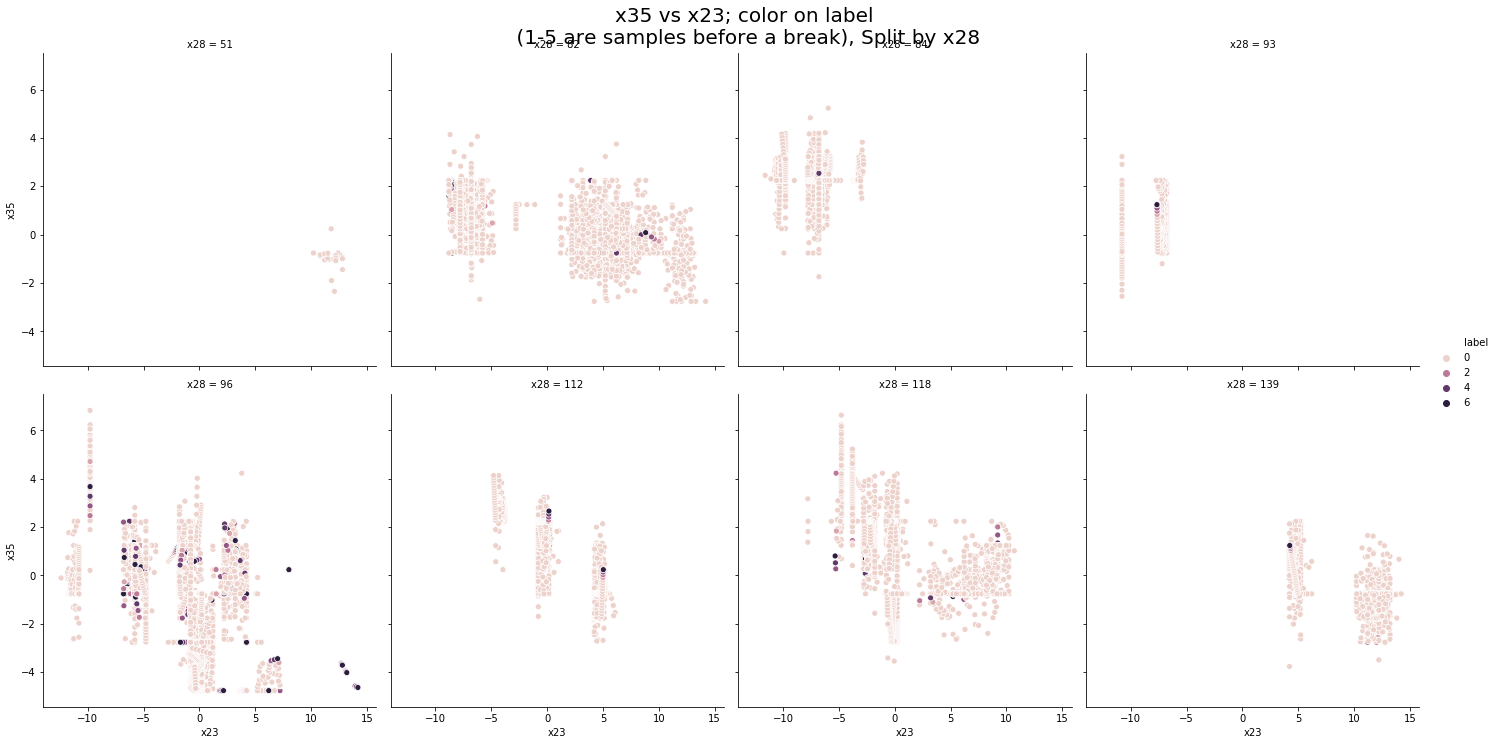

In [70]:
g=sns.relplot(x = 'x23', y = 'x35', data = df[df['y']==0] , hue = 'label', col = 'x28', col_wrap = 4 )
g.fig.suptitle("x35 vs x23; color on label\n (1-5 are samples before a break), Split by x28", y=1.03, fontsize = 20)
plt.show()

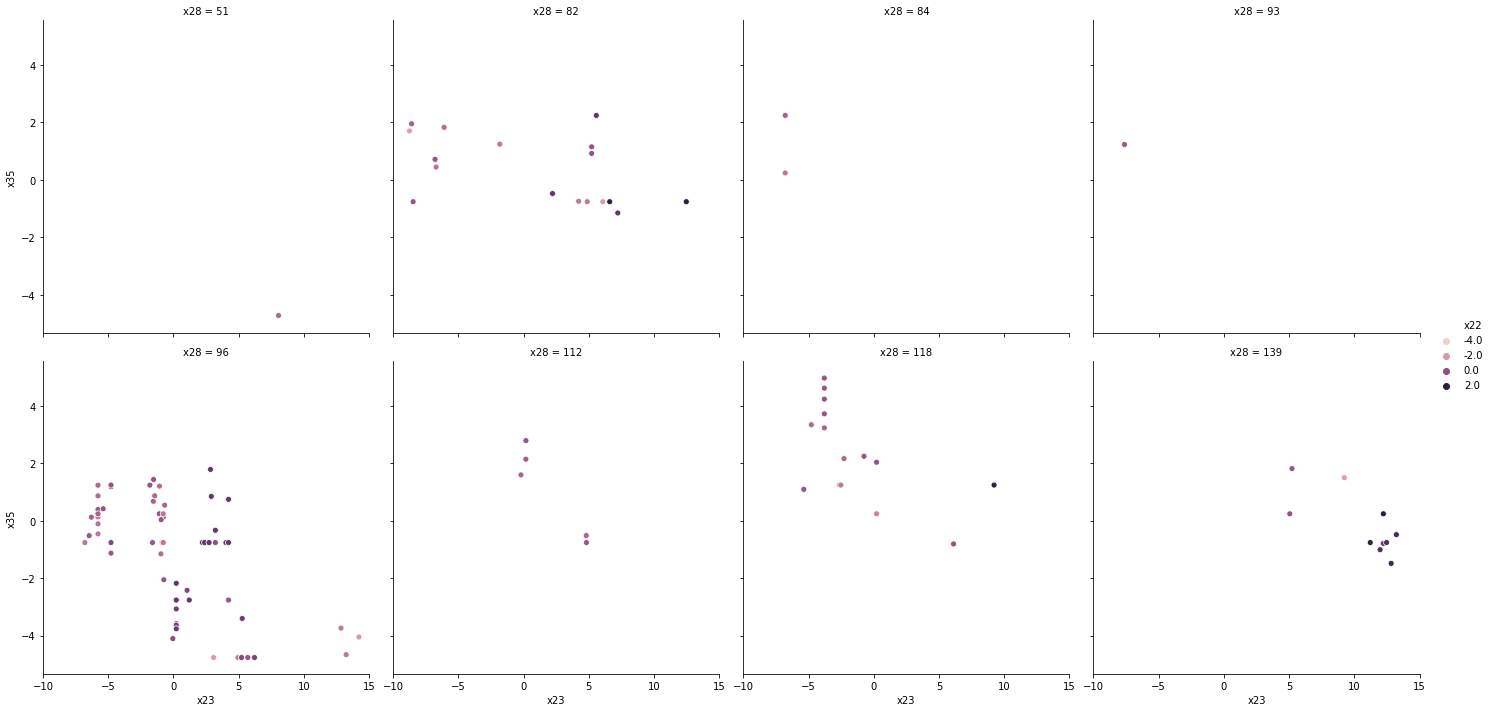

In [71]:
sns.relplot(x = 'x23', y = 'x35', data = df[df['y']==1] , hue = 'x22', col = 'x28', col_wrap = 4)
plt.xlim(-10,15)
plt.show()

### Look for other feature leads in the highest feature importance subset pairplot for linkages to the semi-categorical features x28 & x22 ( Plotting with x23, x35, x52, x53, x54 in place of x28 & x22 yields similar results).
x31 seems to have a relationship with x2, x3, x42, & x45 where most samples are in one group but others are represented by an offset line.  Additionally, x46 has some distinct outliers.  If these differences are related to the sample proximity to a break, then they can be used to predict an impending failure condition.

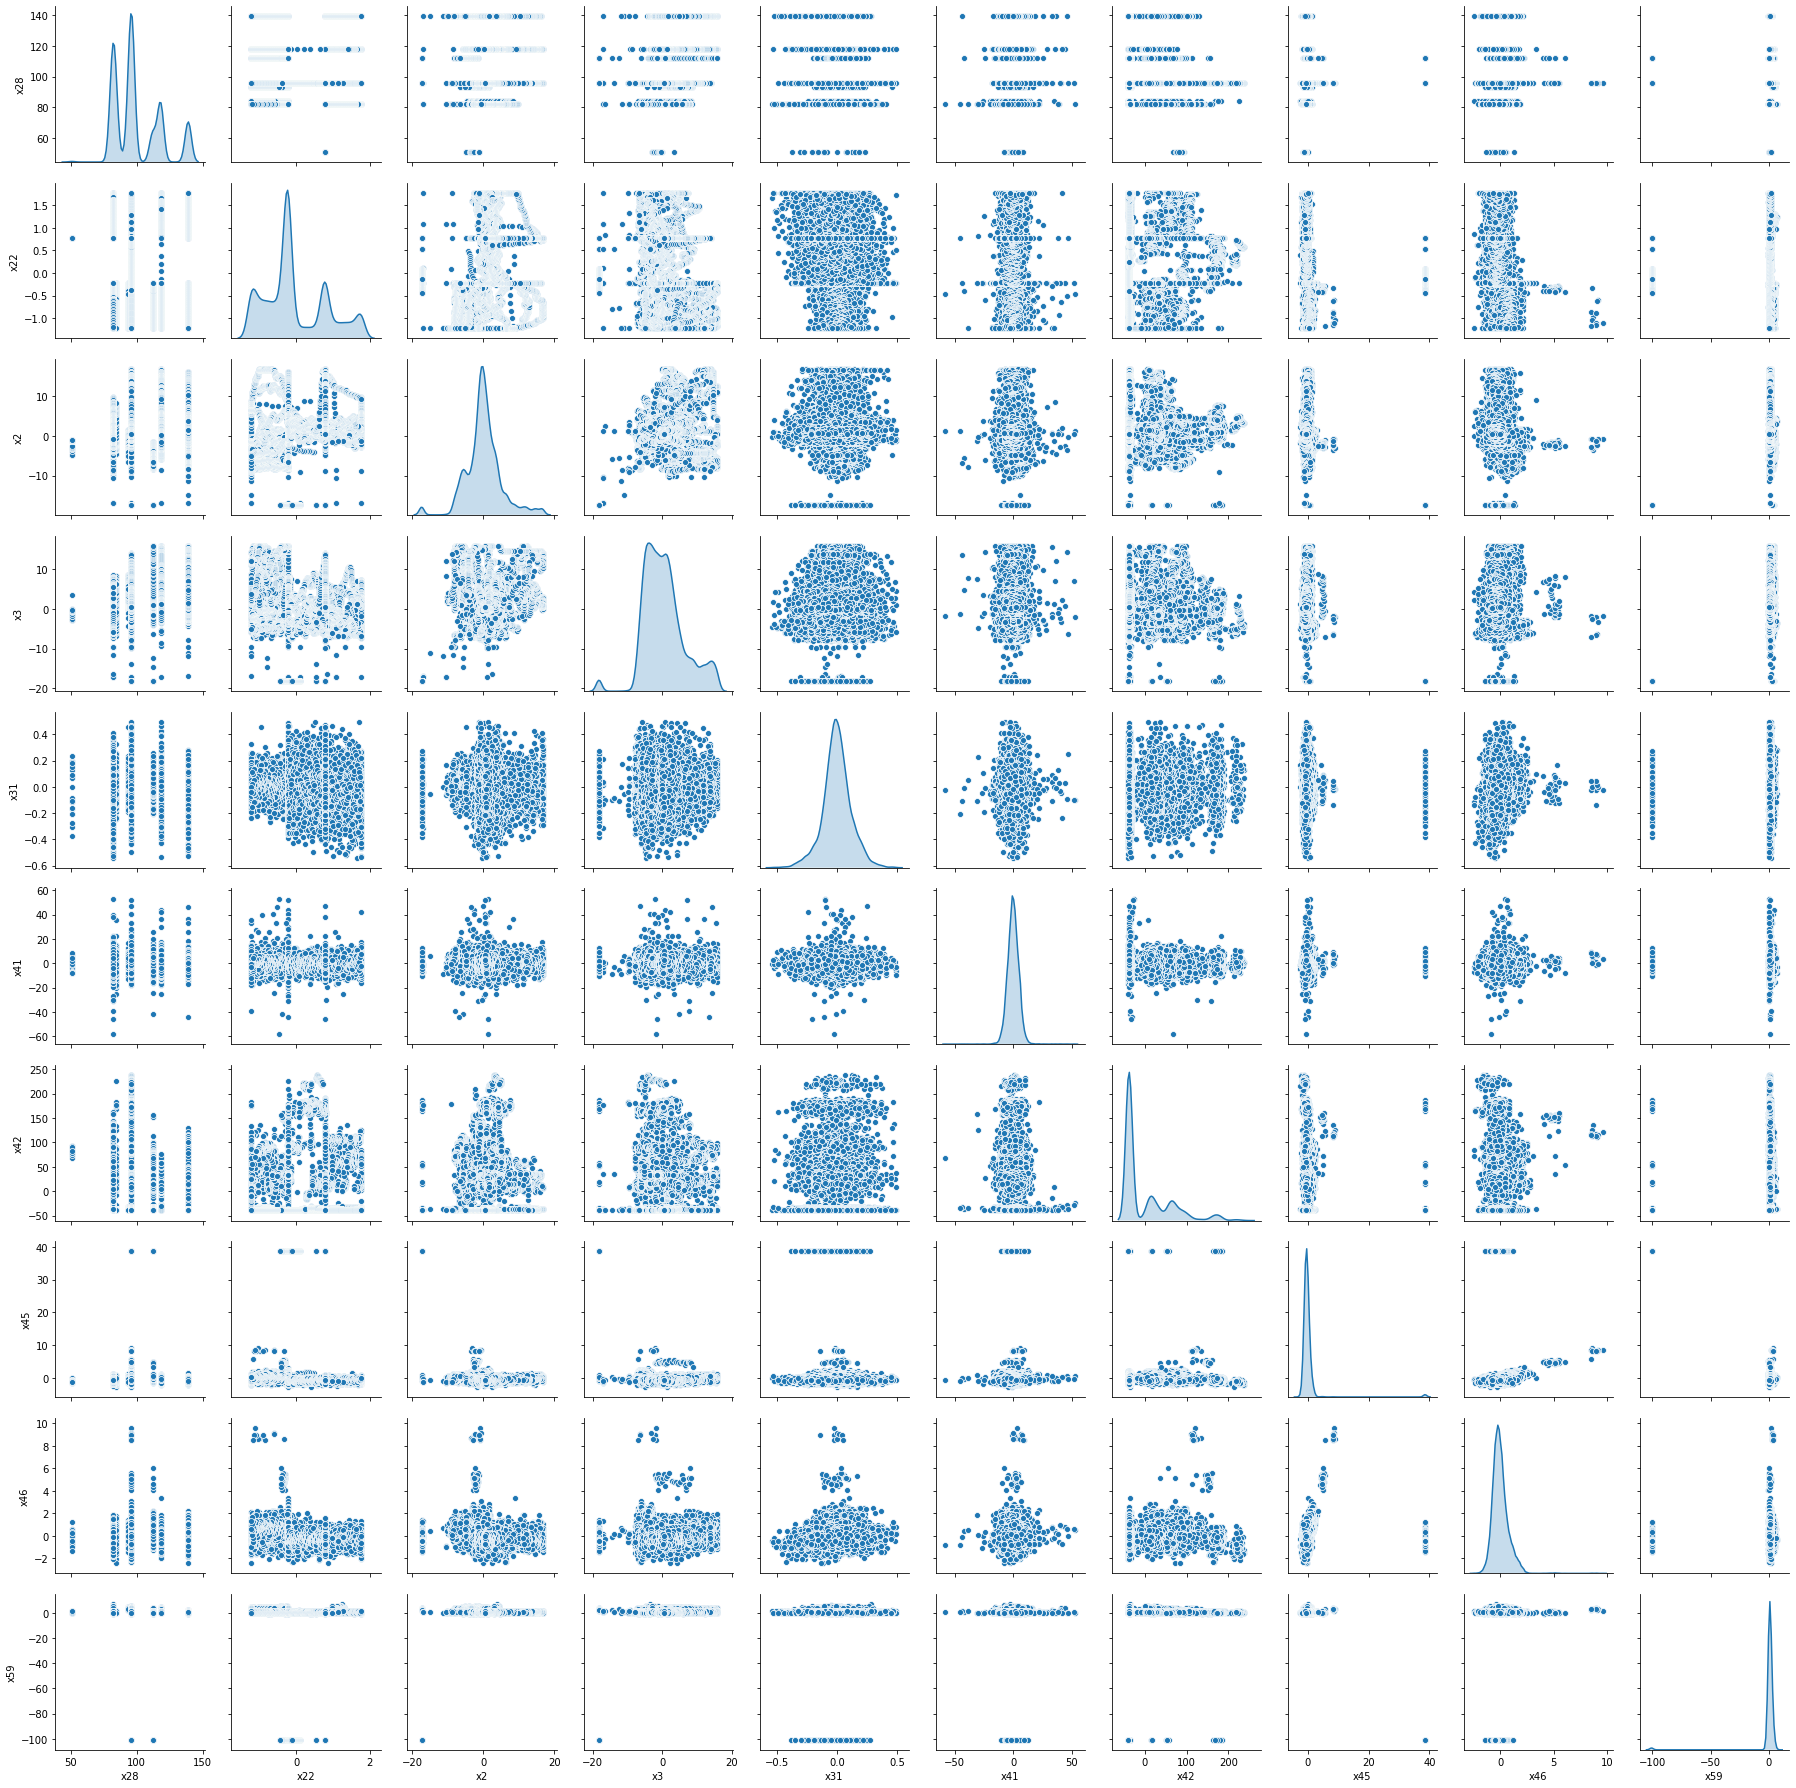

In [72]:
df_plot = df[['x28','x22', 'x2', 'x3', 'x31', 'x41', 'x42', 'x45', 'x46', 'x59']][df['y']==0]
#df_plot = df[['x28','x21', 'x22', 'x23', 'x35']][df['y']==0]
sns.pairplot(df_plot, diag_kind = "kde",kind = "scatter")
plt.show()

#### Look at the interaction between x31 and x42, with x22 and x28.
These are similar to the other comparisons above.

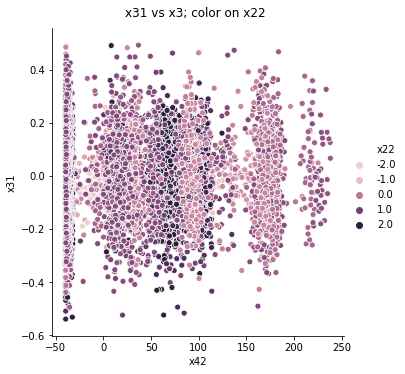

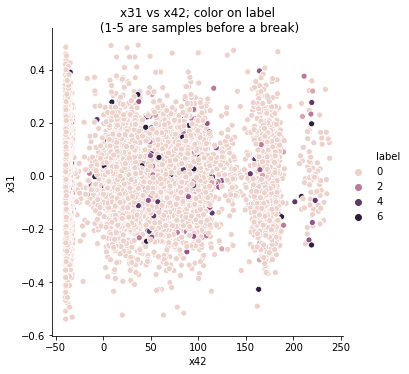

In [73]:
hues, titles =['x22', 'label'], ["x31 vs x3; color on x22", "x31 vs x42; color on label\n (1-5 are samples before a break)"]
for i in [0,1]:
    (RelPlot('x42', 'x31', df[df['y']==0], hues[i], titles[i]) )
plt.show()

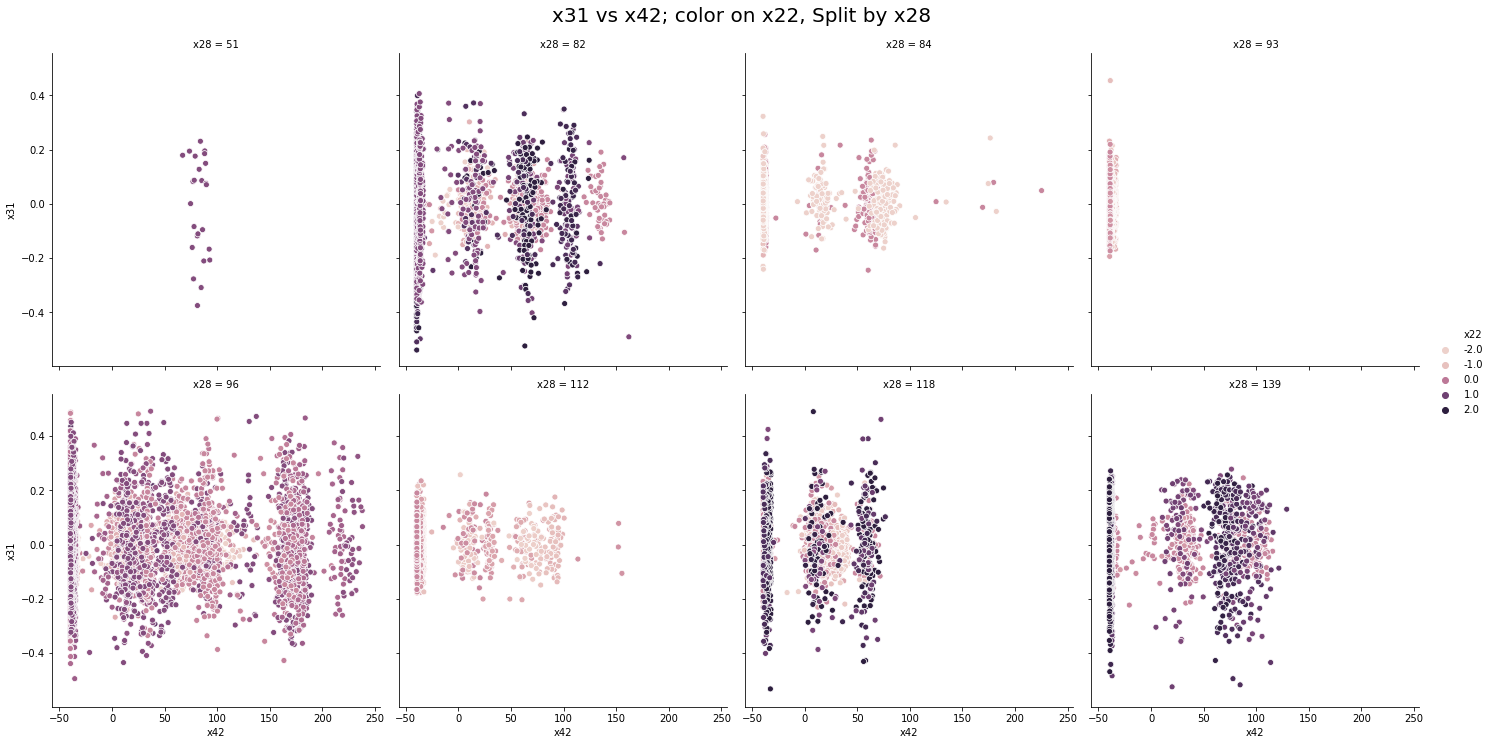

In [74]:
g=sns.relplot(x = 'x42', y = 'x31', data = df[df['y']==0] , hue = 'x22', col = 'x28', col_wrap = 4)
g.fig.suptitle("x31 vs x42; color on x22, Split by x28", y=1.03, fontsize = 20)
#plt.xlim(-10,15), plt.ylim(-15,15)
plt.show()

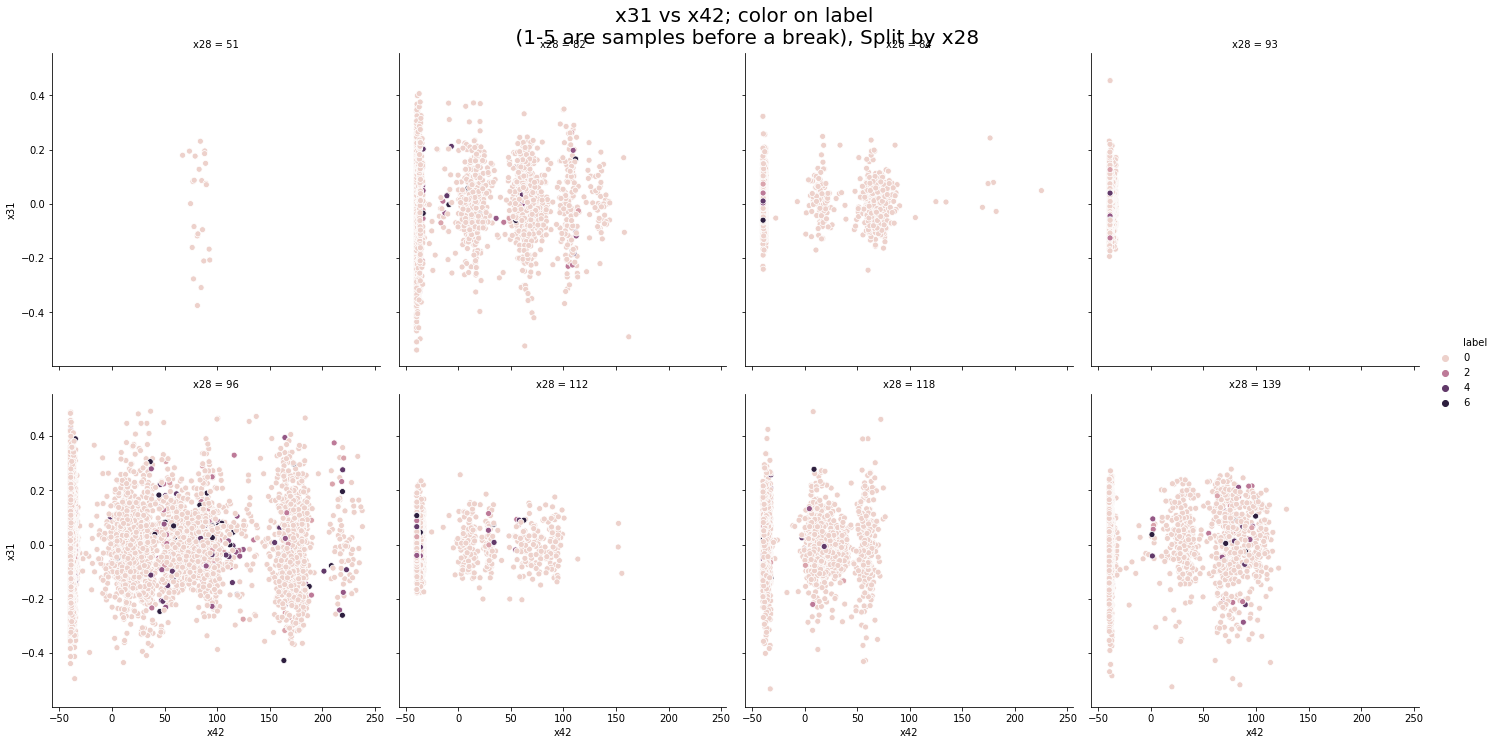

In [75]:
g=sns.relplot(x = 'x42', y = 'x31', data = df[df['y']==0] , hue = 'label', col = 'x28', col_wrap = 4)
g.fig.suptitle("x31 vs x42; color on label\n (1-5 are samples before a break), Split by x28", y=1.03, fontsize = 20)
#plt.xlim(-10,15), plt.ylim(-15,15)
plt.show()

### Plot the lowest elements from feature importance with x28 & x22.

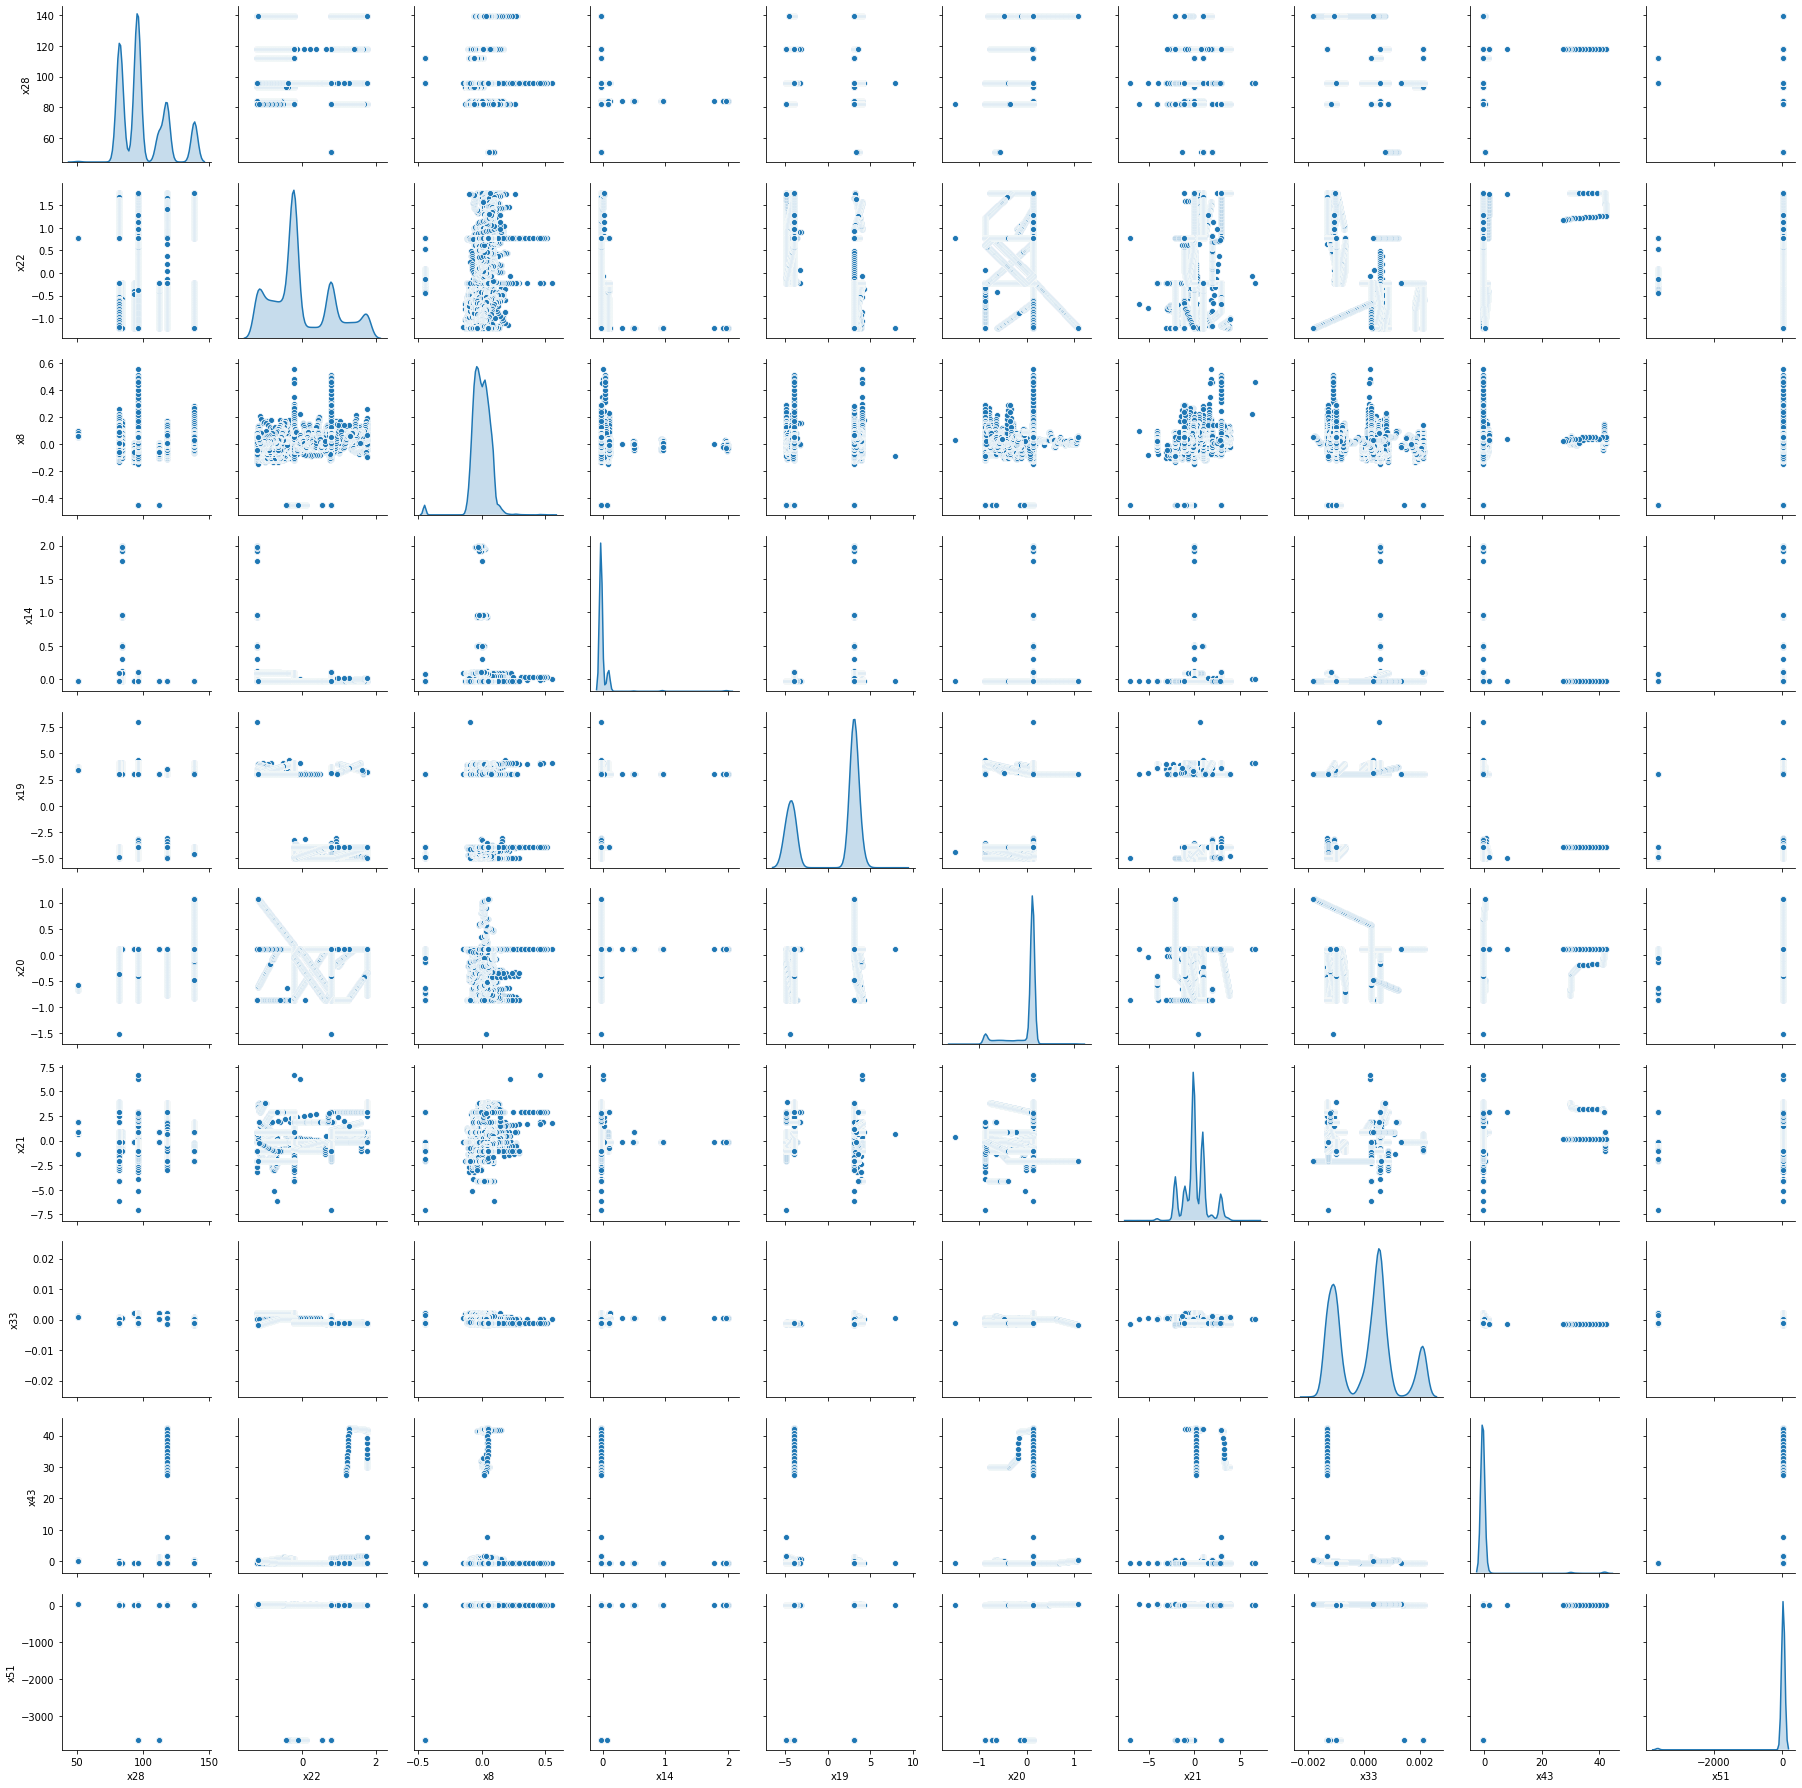

In [76]:
df_plot = df[['x28', 'x22', 'x8', 'x14', 'x19', 'x20', 'x21', 'x33','x43','x51']][df['y']==0]
#df_plot = df[['x28','x21', 'x22', 'x23', 'x35']][df['y']==0]
sns.pairplot(df_plot, diag_kind = "kde",kind = "scatter")
plt.show()

### Now look at the feature stats shift with the labels away from the normal state.   df_stats is used to set the y-limit range below.

The set of box plots below shows that many features do not vary from the normal state, however, some features have a noticable shift in the five samples prior to a sheet break.  Some have a shift in the mean or a shift in the inner quartiles, including features: x6, x13, x29, x34, x36, x37, x40, x42, x44, x47, x52, x54, x55, and x56.

Replot the boxplots but restricting to a single category from x28 to see if there is greater difference for labels 1 through 5.

Compare these noticable features with a feature importance from a random forest classification to reduce training features in models.

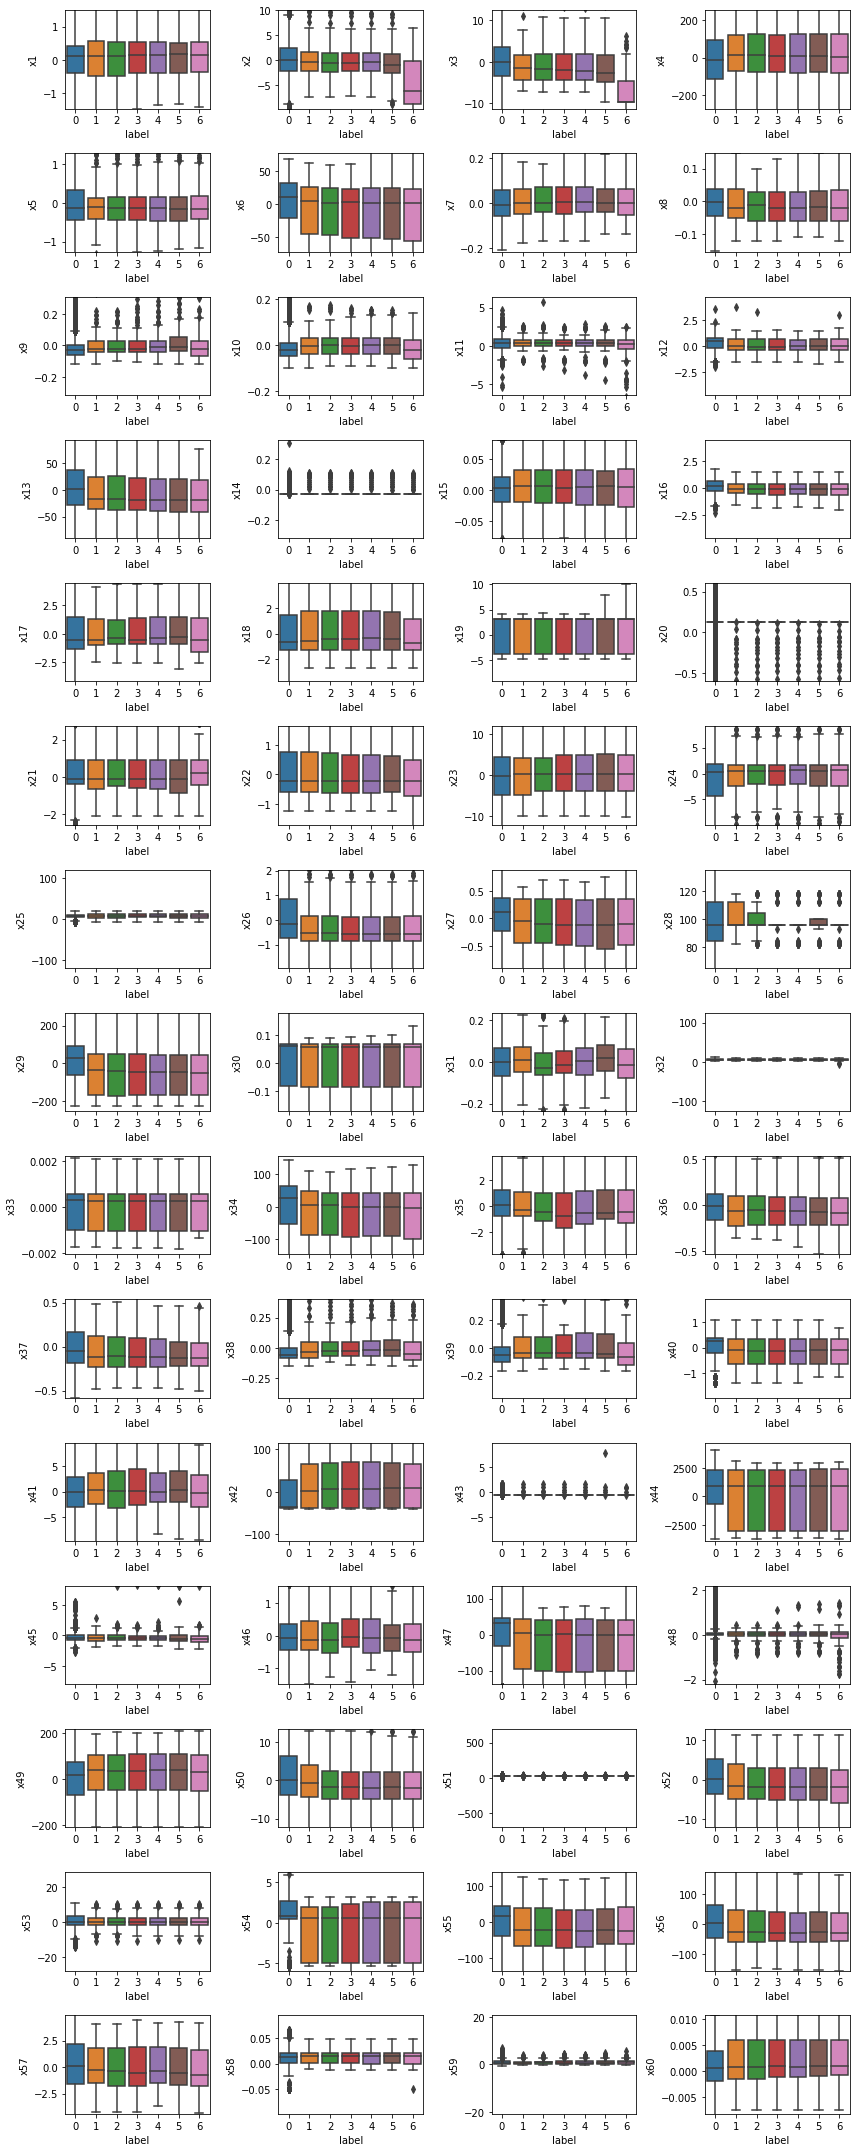

In [77]:
plt.figure(figsize=(12,30))
for i in range(60):
    feature = process_features[i]
    plt.subplot(15,4,i+1)
    plt.grid(False)
    sns.boxplot(df['label'], df[feature], saturation = 0.7)
    plt.ylim(df_stats[feature][1] - 2*df_stats[feature][2], df_stats[feature][1] + 2*df_stats[feature][2])
plt.tight_layout()

### Box Plots with x28 restricted to 96, the most frequent value.
Feature x54 is marketly different than the boxplot for x54 for all values of x28.  x47 also shows greater separation from the normal state with x28 fixed at 96.  Other features also show some noticable difference: x21, x29, x40, x44, and x55. 

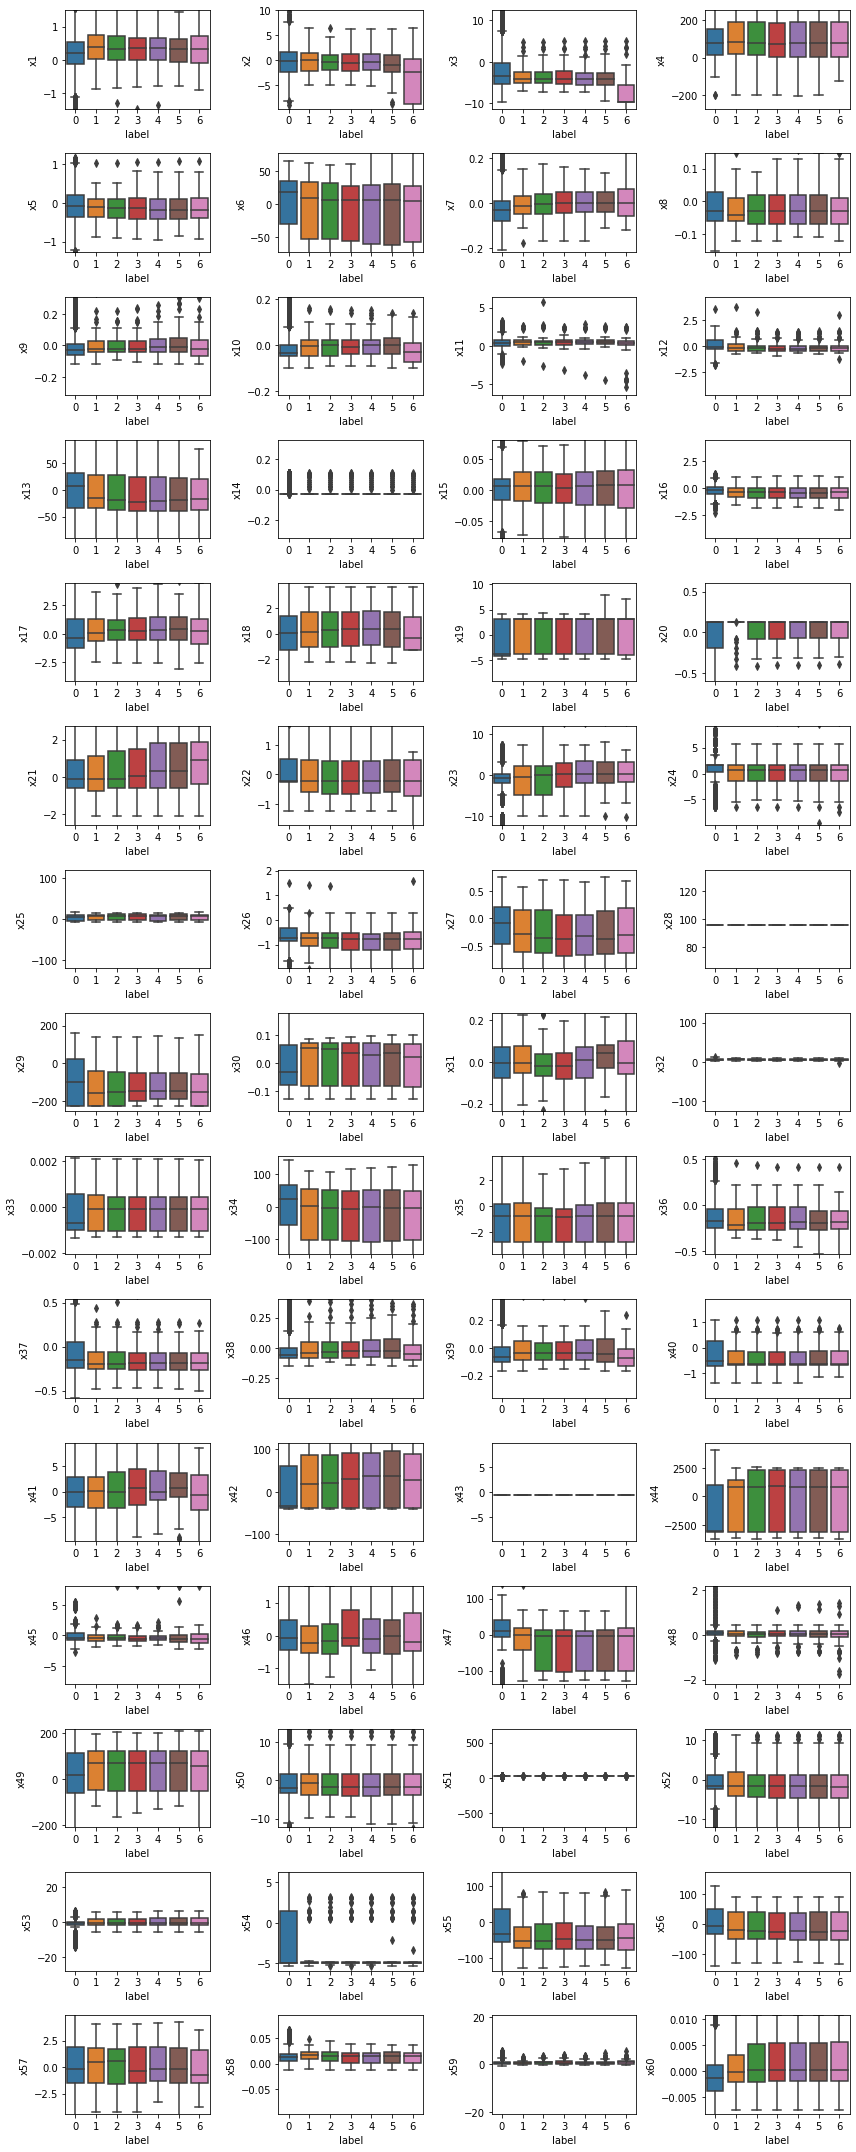

In [78]:
plt.figure(figsize=(12,30))
for i in range(60):
    feature = process_features[i]
    plt.subplot(15,4,i+1)
    plt.grid(False)
    sns.boxplot(df['label'][df['x28']==96], df[feature][df['x28']==96], saturation = 0.7)
    plt.ylim(df_stats[feature][1] - 2*df_stats[feature][2], df_stats[feature][1] + 2*df_stats[feature][2])
plt.tight_layout()

### Box Plot for x28 at 82:
With x28 set at 82, there is a difference in feature x58 for labels 1 through 5.  

Consider building models specific for the set point / category for feature x28.

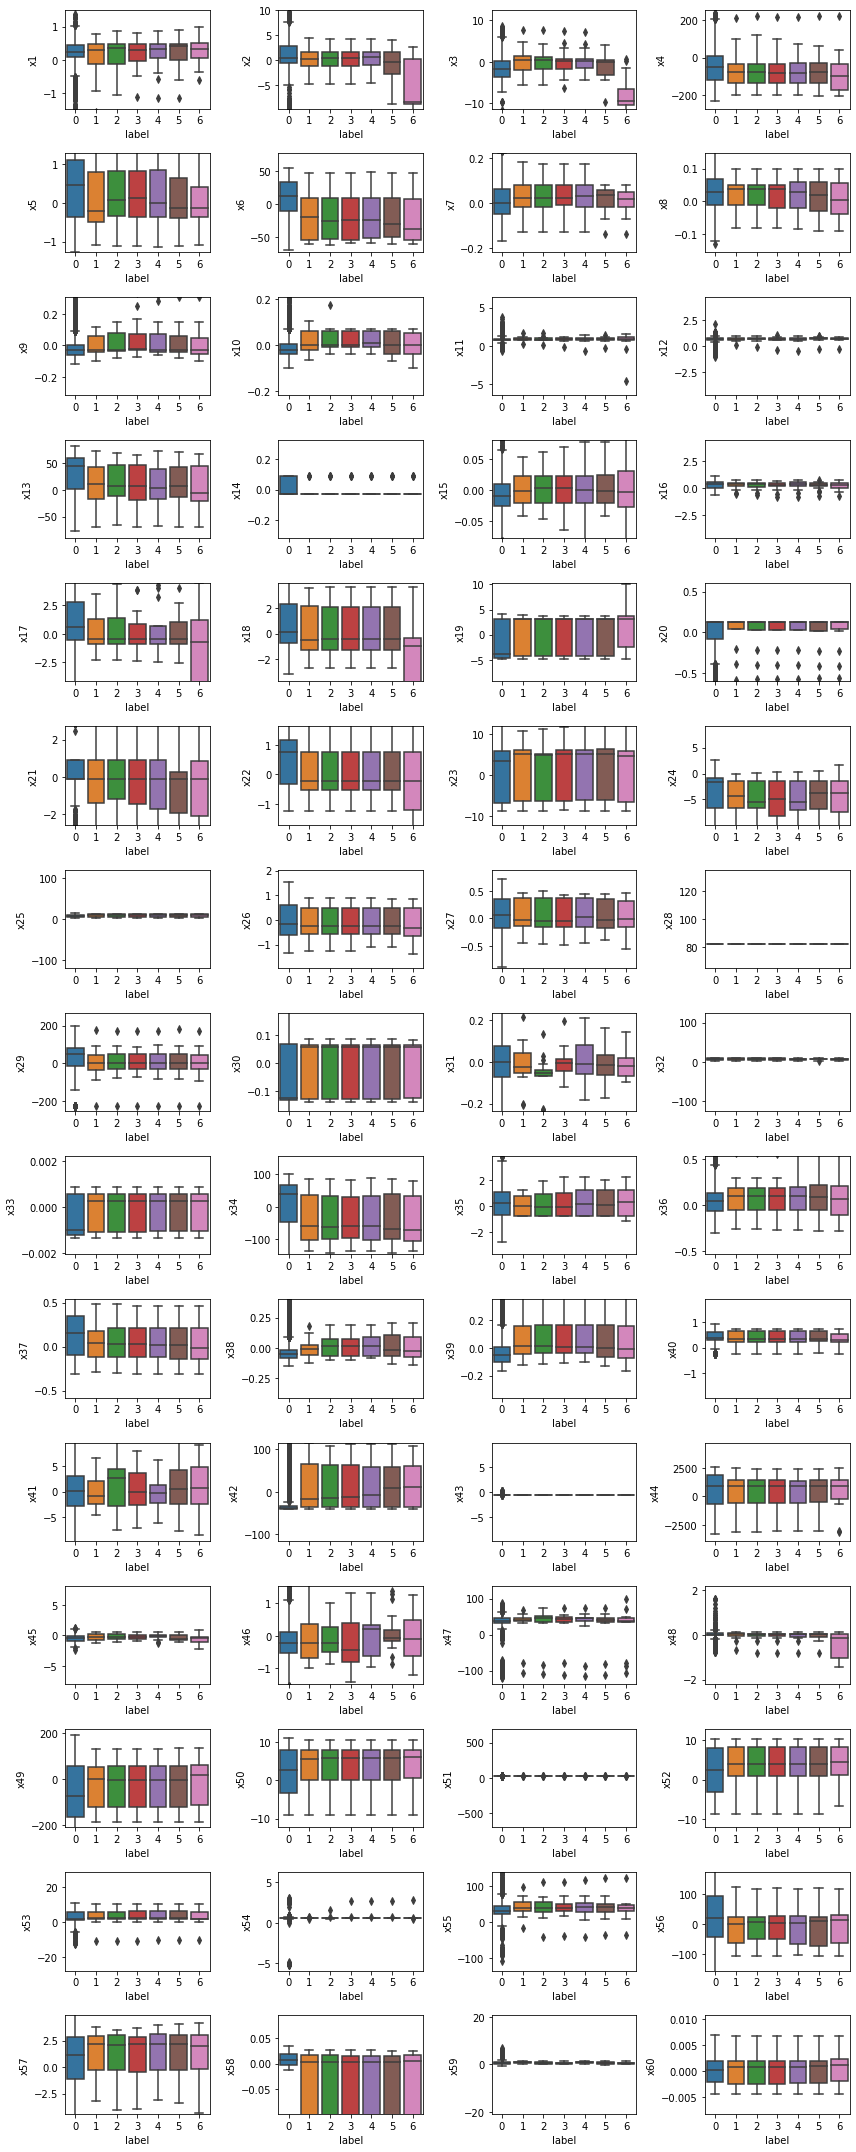

In [79]:
plt.figure(figsize=(12,30))
for i in range(60):
    feature = process_features[i]
    plt.subplot(15,4,i+1)
    plt.grid(False)
    sns.boxplot(df['label'][df['x28']==82], df[feature][df['x28']==82], saturation = 0.7)
    plt.ylim(df_stats[feature][1] - 2*df_stats[feature][2], df_stats[feature][1] + 2*df_stats[feature][2])
plt.tight_layout()